## MSING0097 Group Coursework (Notebook 2) - F5:  

## Time series data continued

In this Notebook you must conduct a similar analysis to the one you worked through in Notebook 1.

To do this we have selected several sources of data, from recent reserach papers and commercial challenge prizes, that you can from the basis of your analysis. 

## MSIN0097: Predictive Analytics (18/19), Group Project, Team Members, Team F5:
- Daria Golova (17145084)<br>
- Bartosz Kultys (18062858)<br>
- Chi Chung Yuen (Kelvin) (15027396)<br>
- Nanistya Respati Probosutedjo (1713278)<br>
- Tjark Petersen (17130626)<br>

<div class="alert alert-warning">
<b>COURSE ASSESSMENT (~1200 words)</b> 

<p>This part of the assessment is based on answering/commenting/making observations on various sections throughout this Notebook.<p> 

<p>Course assessment blocks are highlighted in  orange (same color as this cell) throughout the Notebook.<p> 
<p>Please follow the instructions in each block. Please look at this markup cell and format your responses in a similar manner</p>

<b> NOTE: All comments will be made in blue markup cells for uniformity and ease of identification in unexpected areas, accompanied with word count. 

</div>


## Table of Contents - Project Template

 Load libraries

1. [Problem Comprehention](#problem)
    * Overview
    * Problem Description
 
 
2. [Data Comprehention](#data)
    * Descriptive statistics
    * Data visualizations
  
  
3. [Data Preparation](#prep)
    * Feature engineering
    * Data transformation (normalisation, balancing, spliting)
  
  
4. [Fitting the Algorithms](#alg)
    * Experimental setup
    * Naive forecast
    * Data analysis
    * Linear models 
    * Supervised learning formulation
    * Ensemble methods
    * Advanced methods
  
  
5. [Evaluation](#assesment)
  
  
6. [Finalize Model and Summary](#final)


In [2]:
!pip install keras
!pip install arch

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
    100% |████████████████████████████████| 706kB 757kB/s eta 0:00:01


In [3]:
# Import all required libraries
import pandas as pd
from pandas.tools.plotting import lag_plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import random
from math import sqrt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

#from arch import arch_model #for GARCH

from scipy.stats import probplot, shapiro

from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv2D, MaxPooling2D
from keras import backend as K

#View all columns of dataframes
pd.options.display.max_columns = None

#View all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

#pretty printing of dataframes in Jupyter notebook
import IPython
from IPython import display


Using TensorFlow backend.


-------------------------


<br>
<div class="alert alert-success">
<h1 align="center"> 1. Problem Comprehension </h1> <br>
<a id="problem"></a>

## 0. Overview

Please set out the selected data set/s you will use for your analysis.

In [4]:
%%time
# load the data
d = pd.read_csv('household_power_consumption.txt', sep=';')

CPU times: user 2.67 s, sys: 236 ms, total: 2.9 s
Wall time: 2.33 s


In [5]:
%%time
# The first value of Sub_metering_1 is 0 whoich will lead to an ffill of 0 later on, quick solution:
d.Sub_metering_1 = d.Sub_metering_1.convert_objects(convert_numeric=True)
d.iloc[0,6] = d.Sub_metering_1.mean()
# as seen above, missing values are marked with "?", % of nan values, then median imputation
df = d
df = df.replace(to_replace='?', value= np.nan)
df = df.replace(to_replace= '0.000', value= np.nan)
df = df.replace(to_replace= '0', value= np.nan)
df = df.replace(to_replace= '0.0', value= np.nan)
df = df.replace(to_replace= 0, value= np.nan)

def check_null(data):
    nlist = list()
    for col in data.columns:
        nlist.append(len([i for i in data[col].isnull() if i==True])/data.shape[0])
    labels = [i for i in data.columns]
    d_null=pd.DataFrame({'Columns': labels, 'Null%': nlist})
    return d_null

check_null(df)

# NAN values but only 1.25% in each column,impute forward
df.fillna(method = 'ffill', inplace=True)
print('Imputation done.')

# check whether imputation is complete
print(check_null(df))

# make numbers floats
d = df.convert_objects(convert_numeric=True)

# check whether dtype has been converted to float
print(d.info())

Imputation done.
                 Columns  Null%
0                   Date    0.0
1                   Time    0.0
2    Global_active_power    0.0
3  Global_reactive_power    0.0
4                Voltage    0.0
5       Global_intensity    0.0
6         Sub_metering_1    0.0
7         Sub_metering_2    0.0
8         Sub_metering_3    0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB
None
CPU times: user 23.6 s, sys: 2.14 s, total: 25.7 s
Wall time: 17.2 s


In [6]:
%%time
# deal with date time format - takes couple of minutes though but gives us a time series element (datetime object) which is useful:
d.loc[:,'log'] = pd.to_datetime(df.Date.astype(str)+' '+d.Time.astype(str))
d = d.set_index(pd.DatetimeIndex(d['log']))
d.drop(columns=['log'],inplace = True)
d = d.resample('D').sum()

CPU times: user 3min 8s, sys: 228 ms, total: 3min 8s
Wall time: 3min 7s


In [7]:
d.head()

Global_active_power  Global_reactive_power    Voltage  \
log                                                                 
2006-12-16             1209.176                 44.942   93552.53   
2006-12-17             3390.460                238.658  345725.32   
2006-12-18             2203.826                194.526  347373.64   
2006-12-19             1666.194                204.410  348479.01   
2006-12-20             2225.748                201.092  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
log                                                                           
2006-12-16            5180.8      444.281631           797.0          5862.0  
2006-12-17           14398.6     3466.958222          5153.0         19464.0  
2006-12-18            9247.2     2475.000000          3790.0         20050.0  
2006-12-19            7094.0     2313.000000          8417.0         15904.0  
2006-12-20            9313.0     1440.000000          3939.0         20147.0

<div class="alert alert-block alert-info">
    <b>SECTION COMPREHENSION</b>
    
 1.25% of each attributes have missing values ('?'s and '0's). Unknown values have been replaced with NaNs and further imputed with values of the previous time period. Dtype is converted into floats for improved data comprehension and the data resampled to daily.

<b>
<b>
Word count: 42
</div>

## 1. Problem Description

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
A dataset regarding electricity usage is provided for a household. 

Key metrics: 

- four years (2006 - 2010);
- recorded every minute;
- 2,075,259 records; and
- seven variables (active power, reactive power, voltage, global intensity, sub-metering 1, sub-metering 2, and sub-metering 3). 

<br>
Purpose: use historical data to predict future energy consumption rates. ARIMA model is used, and further corrected using alternative models e.g. random forests, and LSTMS. 
<br>
<br>
Benefits the study:

- billing projections for electricity companies; and 
- investment decisions for cost-saving outcomes of more environmentally friendly electricity options. 
<br>
<br>
Word count: 93

</div>

<br>
<div class="alert alert-success">
<h1 align="center"> 2. Data Comprehension </h1> <br>
<a id="data"></a>

In [7]:
d.shape
d.head(8)
d.info()
d.describe()

(1457, 7)

Global_active_power  Global_reactive_power    Voltage  \
log                                                                 
2006-12-16             1209.176                 44.942   93552.53   
2006-12-17             3390.460                238.658  345725.32   
2006-12-18             2203.826                194.526  347373.64   
2006-12-19             1666.194                204.410  348479.01   
2006-12-20             2225.748                201.092  348923.61   
2006-12-21             1717.112                198.994  347100.89   
2006-12-22             2341.338                220.158  347305.75   
2006-12-23             4773.386                234.020  345795.95   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
log                                                                           
2006-12-16            5180.8      444.281631           797.0          5862.0  
2006-12-17           14398.6     3466.958222          5153.0         19464.0  
2006-12-18            9247.2     2475.000000          3790.0         20050.0  
2006-12-19            7094.0     2313.000000          8417.0         15904.0  
2006-12-20            9313.0     1440.000000          3939.0         20147.0  
2006-12-21            7240.6     7514.000000          4114.0         21596.0  
2006-12-22            9897.0    13877.000000          1590.0         20324.0  
2006-12-23           20200.4     7907.000000          1722.0         19422.0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1457 entries, 2006-12-16 to 2010-12-11
Freq: D
Data columns (total 7 columns):
Global_active_power      1457 non-null float64
Global_reactive_power    1457 non-null float64
Voltage                  1457 non-null float64
Global_intensity         1457 non-null float64
Sub_metering_1           1457 non-null float64
Sub_metering_2           1457 non-null float64
Sub_metering_3           1457 non-null float64
dtypes: float64(7)
memory usage: 91.1 KB


Global_active_power  Global_reactive_power        Voltage  \
count          1457.000000            1457.000000    1457.000000   
mean           1547.069765             206.021095  343039.611949   
std             621.106261              50.084422   35760.343966   
min               0.000000               0.000000       0.000000   
25%            1156.478000             174.532000  345667.330000   
50%            1533.422000             203.138000  346973.750000   
75%            1888.022000             233.184000  348287.290000   
max            4773.386000             437.808000  356306.410000   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count       1457.000000     1457.000000     1457.000000     1457.000000  
mean        6557.969938     7886.135374     3090.267673    13233.454358  
std         2574.874351     9564.442254     2125.464184     5461.628561  
min            0.000000        0.000000        0.000000        0.000000  
25%         4971.400000     2351.000000     1692.000000     9162.000000  
50%         6505.200000     3543.000000     1930.000000    13194.000000  
75%         7953.200000     8811.000000     3998.000000    17645.000000  
max        20200.400000    53280.000000    13139.000000    27360.000000

<br>
<div class="alert alert-warning">
<b>1. ASSESSMENT (~100 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
The code in this second section will be clarified through visualisations in section 3.3 - Data analysis. 
<br>
<br>
Word count: 17

</div>

<br>
<div class="alert alert-success">
<h1 align="center"> 3. Data Preparation </h1> <br>
<a id="prep"></a>

In [8]:
# Please see previous data preparations in the overview section of this notebook.

<br>
<div class="alert alert-warning">
<b>1. ASSESSMENT (~100 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<br>
<div class="alert alert-success">
<h1 align="center"> 4. Fitting the Algorithms </h1> <br>
<a id="alg"></a>

## 1. Experimental Setup

In [9]:
#spliting data into train/test
split = int(0.5 * len(d))
train, test = d.iloc[:split].reset_index(), d.iloc[split:].reset_index()

train.to_csv('train.csv',index=False, index_label=False)
test.to_csv('test.csv',index=False, index_label=False)

<br>
<div class="alert alert-warning">
<b>2. ASSESSMENT (~100 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
Initially, a training set of 10% was allocated. However, to improve performance of the model, training set will be set as 50%. In some cases, increased to 60% for comparison. 
<br>
<br>
Word count: 30

</div>

## 2. Naive forecast

In [10]:
from sklearn.metrics import mean_squared_error
# Persistence model from the NB1
# data - assume a dailre resample and a weekly time frame for the forecasting
# persostance does not train a model so only the test data is needed here -> assue test_data
# the persistence model forecasts the value for Monday in week 1 as Monday in week 2

# get a data frame with the original columns and the shifted columns, remove the first 7 values (nans due to shift), called per_df
test_df = test 

cols = ['Global_active_power', 'Global_reactive_power','Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
per_df = pd.DataFrame() 
rmse_vector = list()
for k in cols:
    temp_df = pd.concat([test_df[k].shift(7)[7:], test_df[k][7:]], axis=1)
    temp_df.columns = [k+'_'+'t', k+'_'+'t+7']
    per_df = pd.concat([per_df, temp_df], axis=1)
    l1 = temp_df.iloc[:,0].astype(float)
    l2 = temp_df.iloc[:,1].astype(float)
    rmse_vector.append(sqrt(mean_squared_error(l1,l2)))
evaluation_df = pd.DataFrame(columns = cols)
evaluation_df.loc[0] = rmse_vector
evaluation_df

Global_active_power  Global_reactive_power       Voltage  Global_intensity  \
0           752.677377              74.002637  70676.385458       3106.837764   

   Sub_metering_1  Sub_metering_2  Sub_metering_3  
0    13671.076527     2603.553525     6749.550352

<br>
<div class="alert alert-warning">
<b>3. ASSESSMENT (~100 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
Base model: persistence.
<br>
<br>
Multi-step prediction is set to create a weekly forecast, therefore utilising a t-7 value for t. The analysis focuses on 'Global_active_power' only. The RMSE of 753 kilowatts is relatively high to the mean global active consumption of 1500. 
<br>
<br>
Word count: 41

</div>

## 3. Data Analysis

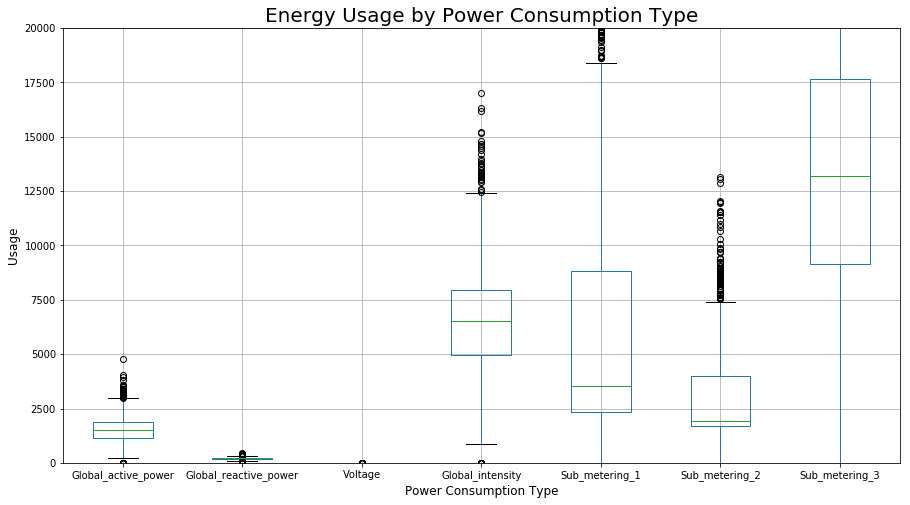

In [11]:
# show boxplot to understand range of values for each measure of energy
d.boxplot(return_type ='dict', figsize=(15,8))
plt.ylim(0,20000)
plt.xlabel('Power Consumption Type', fontsize=12)
plt.ylabel('Usage', fontsize=12)
plt.title('Energy Usage by Power Consumption Type', fontsize=20)
pyplot.show();

In [9]:
# Sub-metering 3 is notably more varied compared to energy consumption rates of the remaining power consumption types, with global_reactive power 
# showing least variation. It should also be noted that measures for voltage are much higher and is beyond the presentable range. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2b5b972b0>,
      dtype=object)

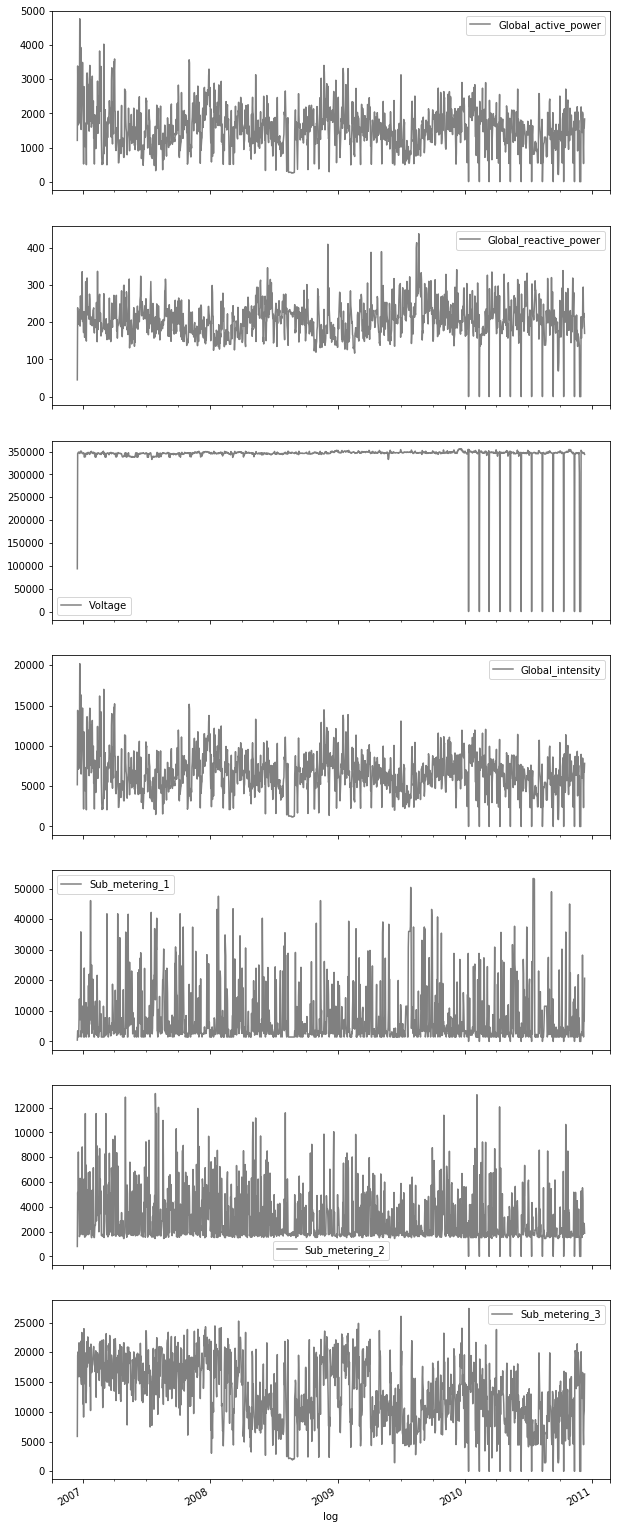

In [12]:
# convert dataset into series 
d_series = pd.DataFrame(data=d)

# create plot for seven attributes to see trend
d_series.plot(subplots=True, color='grey', figsize=(10,30))
pyplot.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2b5e8f6d8>,
      dtype=object)

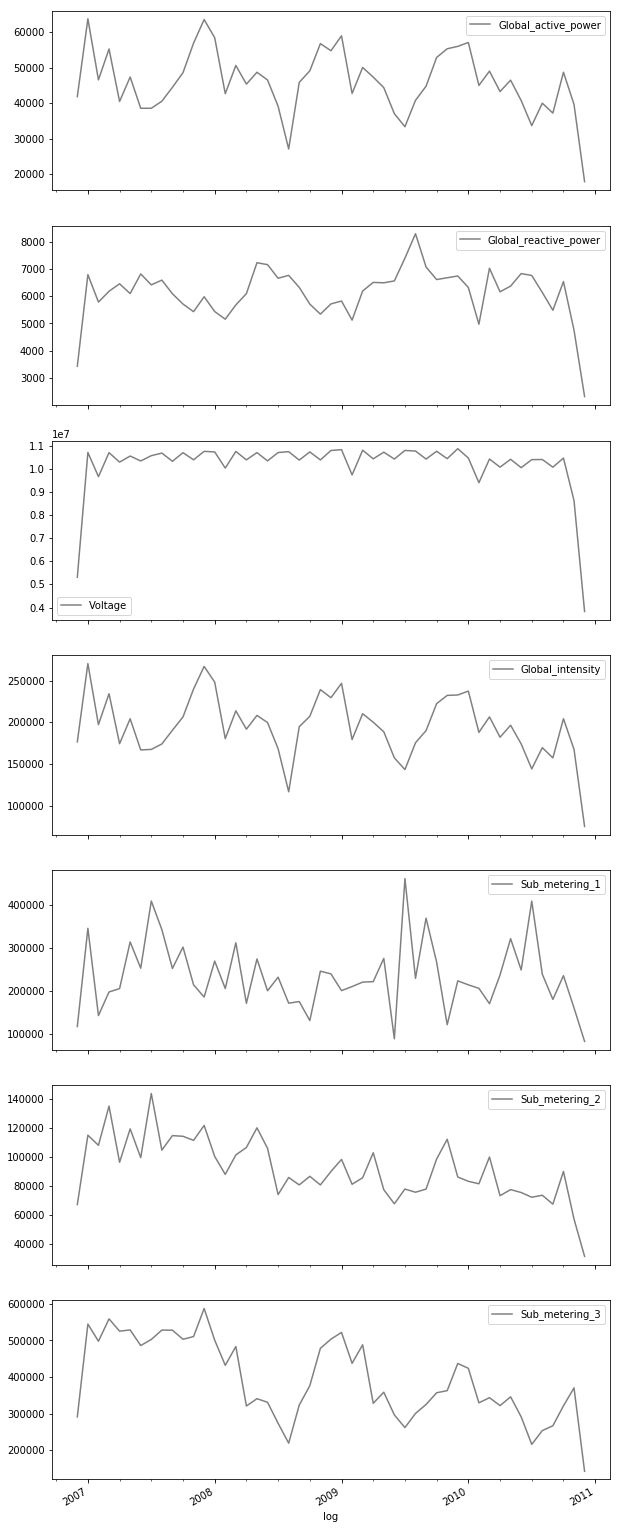

In [13]:
# because trend is still not clear, possibly seeing total on a monthly basis will help identify trend 
d2_series = d.resample('M').sum()
d2_series.plot(subplots=True, legend=True, color='grey', figsize=(10,30))

In [12]:
# After converting the dataset into monthly basis, the trends appear to be clearer in all energy consumption types except for voltage. 
# Most consumption types show a fall in usage during the mid-year and peaks when introduced to a new month. 
# However, the trend or seasonality does not appear too apparent throughout and therefore can be considered as residual. 

Text(0.5, 1.0, 'Global Active Power Lag Plot')

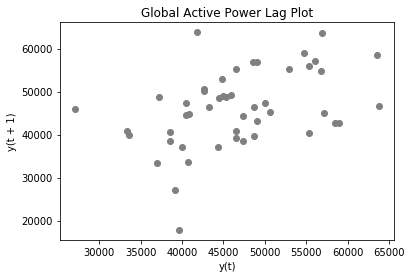

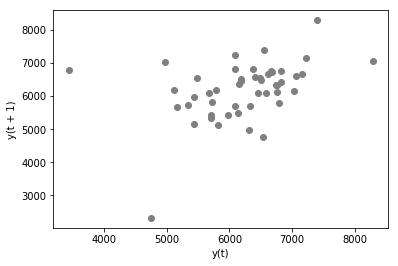

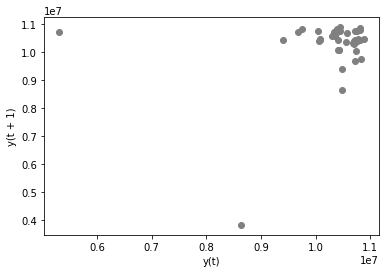

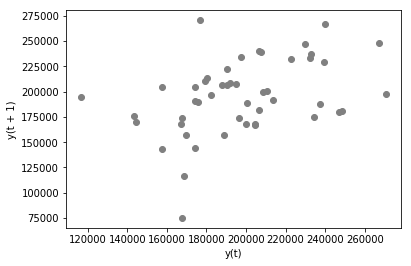

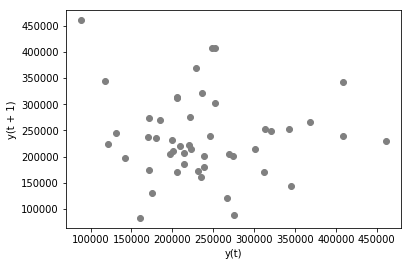

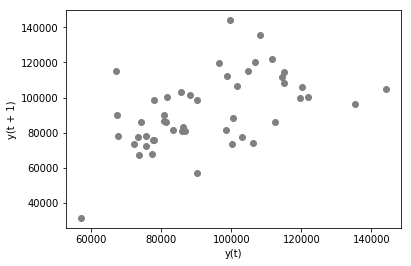

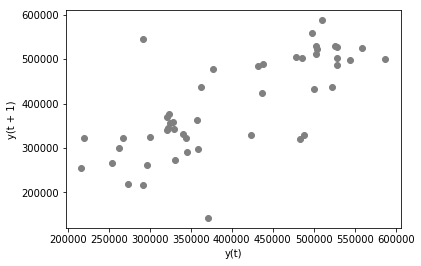

In [14]:
lag_plot(d2_series['Global_active_power'], c='grey')
plt.title('Global Active Power Lag Plot')
pyplot.show()
lag_plot(d2_series['Global_reactive_power'],c='grey')
pyplot.show()
lag_plot(d2_series['Voltage'],c='grey')
pyplot.show()
lag_plot(d2_series['Global_intensity'],c='grey')
pyplot.show()
lag_plot(d2_series['Sub_metering_1'],c='grey')
pyplot.show()
lag_plot(d2_series['Sub_metering_2'],c='grey')
pyplot.show()
lag_plot(d2_series['Sub_metering_3'],c='grey')
pyplot.show()

# edit to make loop and add in title

In [10]:
# The plot shows how a one-step time lag correlates to the present measure. The stronger the correlation (1), the more appropriate the dataset is 
# for ARIMA usage. Measures with the highest correlation include global active power, global reactive power, global intensity, and sub-metering 3. 

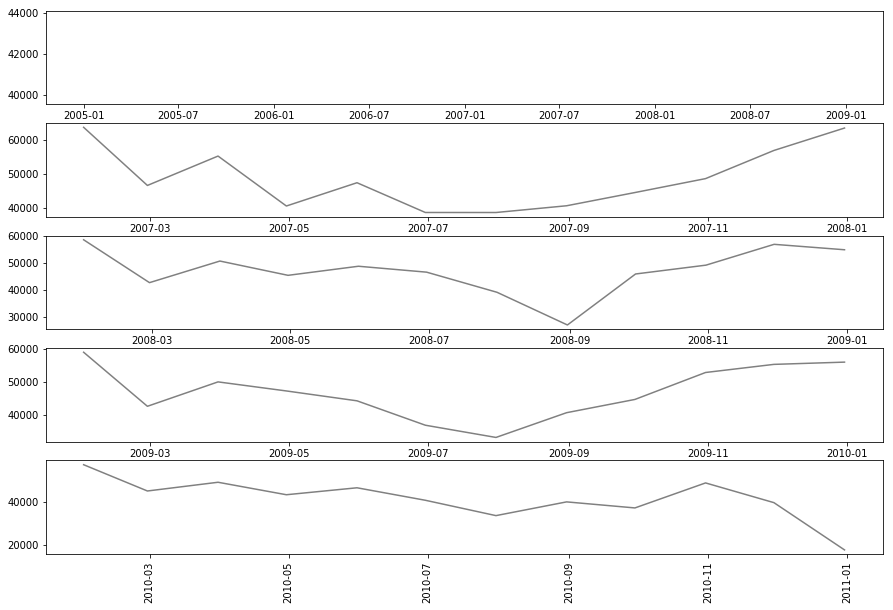

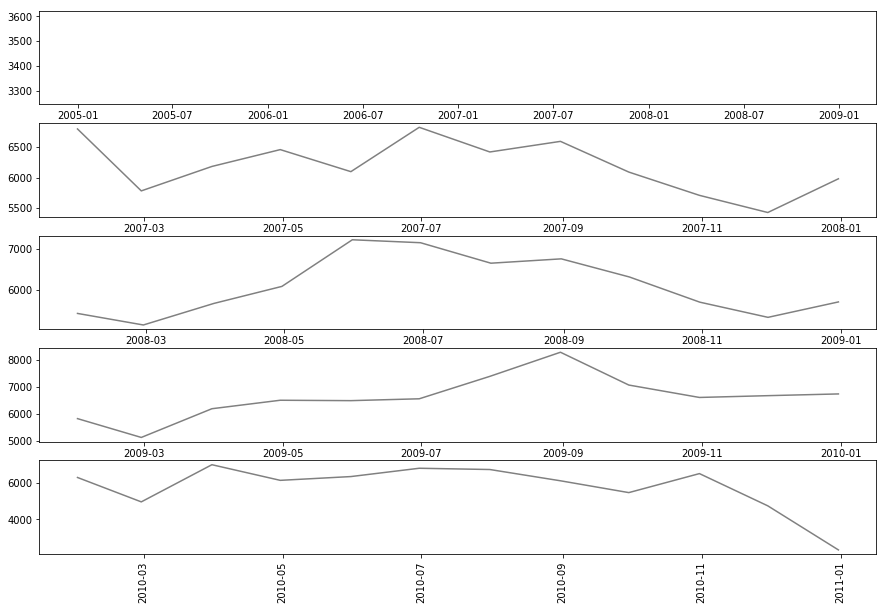

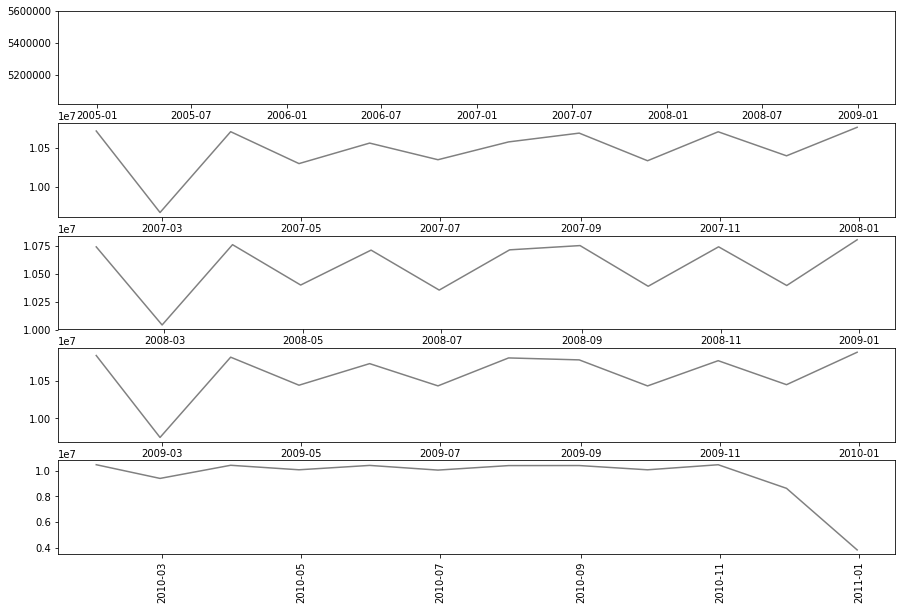

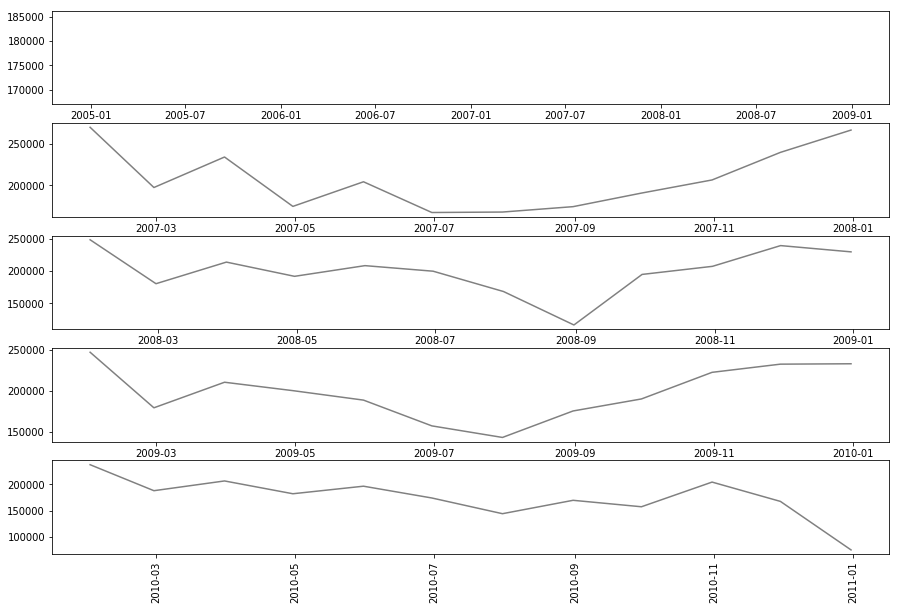

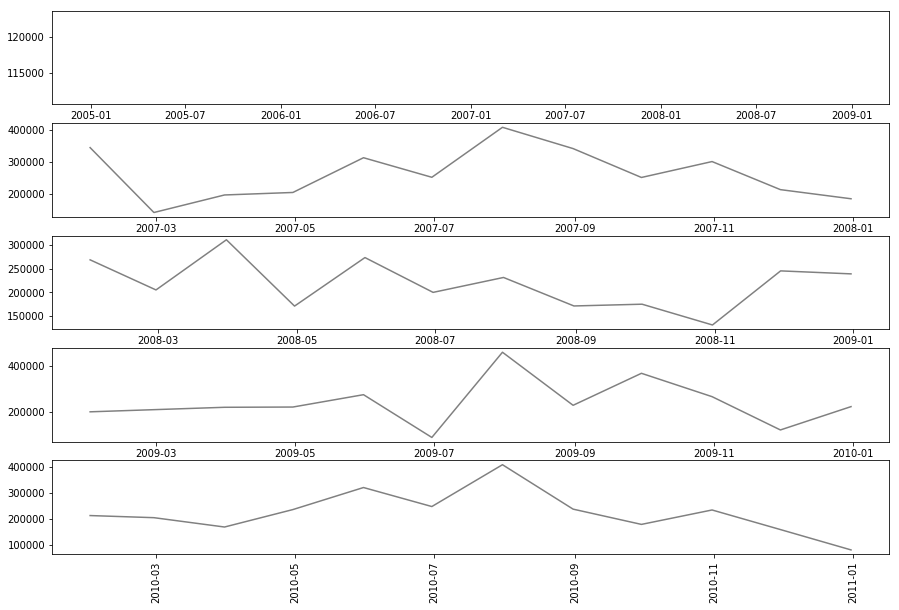

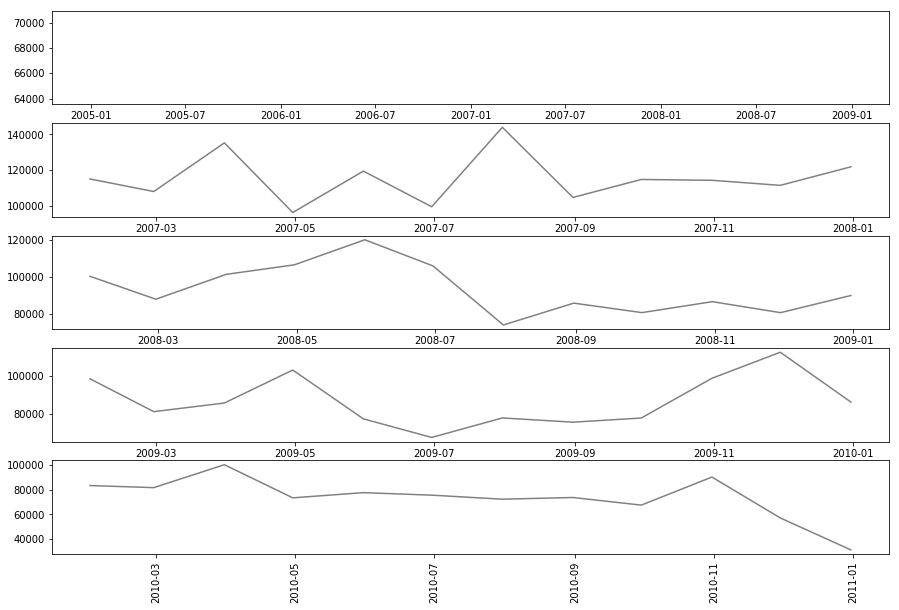

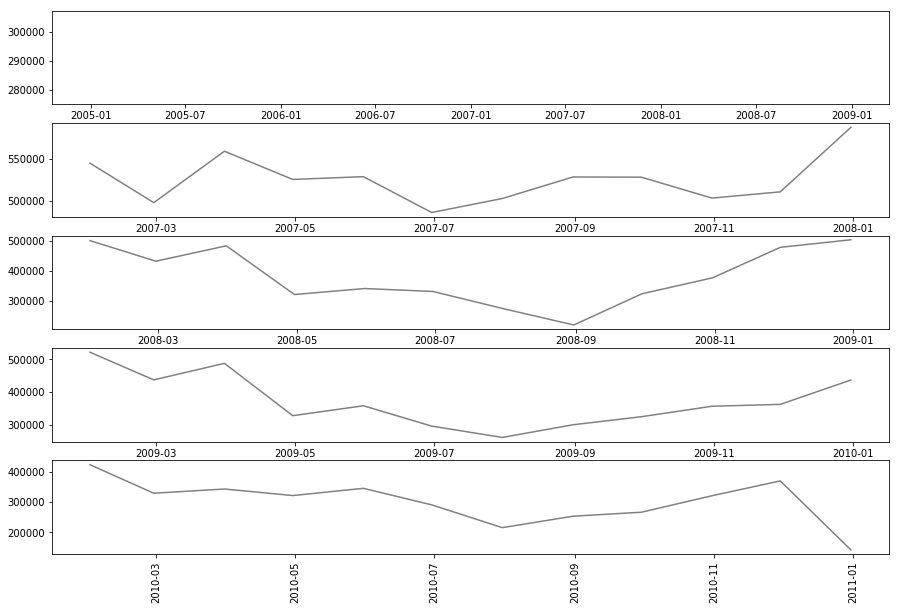

In [15]:
# trend becomes more apparent when values assessed on a monthly basis, therefore will be set for the analysis. To double check monthly trend, a graph plotting yearly measures will be created. 
def plot_series(data):
    pyplot.figure(2, figsize=(15,10))
    groups = data.groupby(pd.Grouper(freq='A'))
    years = pd.DataFrame()
    i=1
    n_groups = len(groups)
    for name, group in groups: 
        pyplot.subplot((n_groups*100) + 10 + i)
        i += 1 
        pyplot.plot(group, color='grey')
    pyplot.xticks(rotation=90)
    return pyplot.show()

plot_series(d2_series['Global_active_power'])
plot_series(d2_series['Global_reactive_power'])
plot_series(d2_series['Voltage'])
plot_series(d2_series['Global_intensity'])
plot_series(d2_series['Sub_metering_1'])
plot_series(d2_series['Sub_metering_2'])
plot_series(d2_series['Sub_metering_3'])


In [11]:
#Note that daily analysis was converted into monthly to increase comprehension of seasonality. 

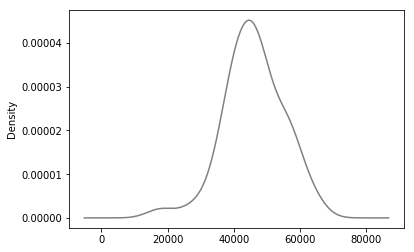

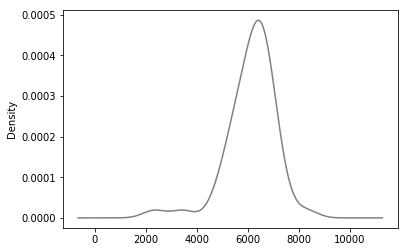

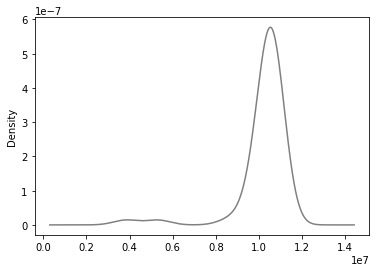

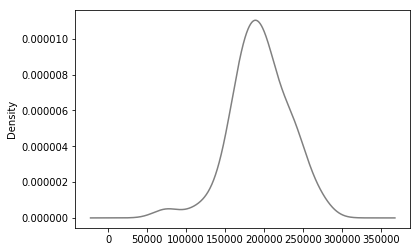

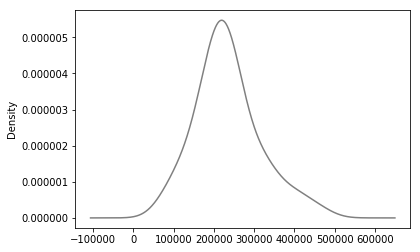

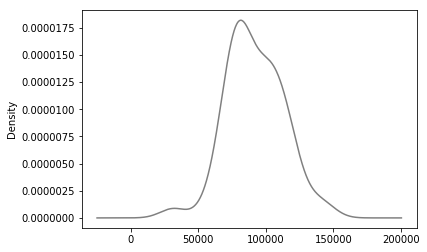

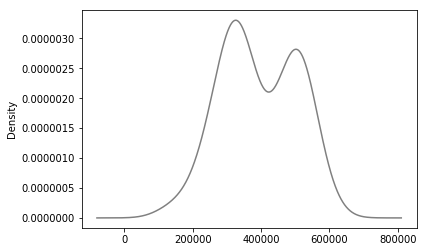

In [16]:
d2_series['Global_active_power'].plot(kind='kde', color='grey')
pyplot.show()
d2_series['Global_reactive_power'].plot(kind='kde', color='grey')
pyplot.show()
d2_series['Voltage'].plot(kind='kde', color='grey')
pyplot.show()
d2_series['Global_intensity'].plot(kind='kde', color='grey')
pyplot.show()
d2_series['Sub_metering_1'].plot(kind='kde', color='grey')
pyplot.show()
d2_series['Sub_metering_2'].plot(kind='kde', color='grey')
pyplot.show()
d2_series['Sub_metering_3'].plot(kind='kde', color='grey')
pyplot.show()

<br>
<div class="alert alert-warning">
<b>4. ASSESSMENT (~200 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>GRAPH COMPREHENSION</b>
Note that daily analysis was converted into monthly to increase comprehension of seasonality. 
It was found that global active power is the most suitable electricity measure to be used for the time series analysis for the following reasons: <br>
<br>
- enough range;<br>
- high correlation in lag plot; and <br>
- completeness. <br>
<br>
Seasonality will be considered, however was inconsistent therefore does not have strong impact.<br>


Word count: 63

## 4. Linear Models

### 4.1 Check Stationarity

In [17]:
# create and summarize stationary version of time series
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    testing = adfuller(data, autolag='AIC')
    output = pd.Series(testing[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in testing[4].items():
        output['Critical Value (%s)'%key] = value
    print (output)

#apply adf test on the series
result1 = adfuller_test(d['Global_active_power'])
print('')
result2 = adfuller_test(d['Global_reactive_power'])
print('')
result3 = adfuller_test(d['Voltage'])
print('')
result4 = adfuller_test(d['Global_intensity'])
print('')
result5 = adfuller_test(d['Sub_metering_1'])
print('')
result6 = adfuller_test(d['Sub_metering_2'])
print('')
result7 = adfuller_test(d['Sub_metering_3'])

Results of Dickey-Fuller Test:
Test Statistic                -8.730466e+00
p-value                        3.201991e-14
#Lags Used                     8.000000e+00
Number of Observations Used    1.448000e+03
Critical Value (1%)           -3.434874e+00
Critical Value (5%)           -2.863538e+00
Critical Value (10%)          -2.567834e+00
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -1.007967e+01
p-value                        1.197830e-17
#Lags Used                     6.000000e+00
Number of Observations Used    1.450000e+03
Critical Value (1%)           -3.434868e+00
Critical Value (5%)           -2.863535e+00
Critical Value (10%)          -2.567832e+00
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -22.163601
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1455.000000
Critical Value (1%)              -3.434852
Critical Value (5%)              -2.863528
C

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

The augmented Dickey-Fuller test was run on all univariate time series to check stationarity. Due to a value of less than 1%, null hypothesis was rejected and time series deemed stationary. 
<br>
<br>
Word count: 31
</div>

### 4.2 Detrend by Differencing

<Figure size 720x576 with 0 Axes>

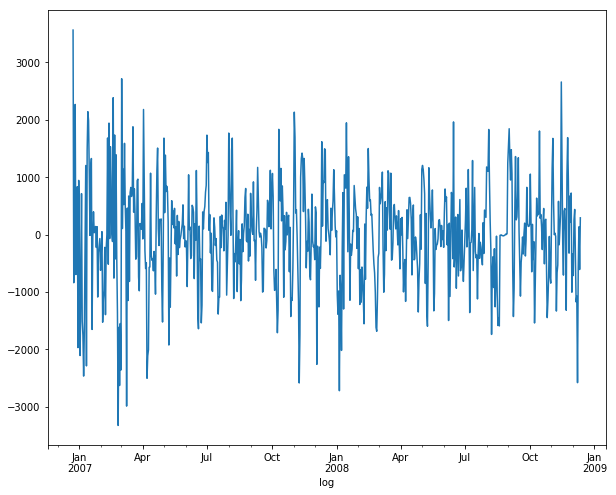

In [13]:
from pandas import Series 
from matplotlib import pyplot
import pylab

# Set series1 for the Global active power variable
df = pd.read_csv('train.csv',header=0);
df['log'] = pd.to_datetime(df['log'].astype(str))
series1 = pd.Series(df['Global_active_power'].values , index=df['log'])


# create a function to difference the series
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

X = series1.values
X = X.astype('float32')

# difference the data by calling the function
days_in_week = 7
stationary1 = difference(X, days_in_week) 
stationary1.index = series1.index[days_in_week:] 

# save as csv
stationary1.to_csv('stationary1.csv') 

# plot
pyplot.figure(5,figsize=(10, 8))
stationary1.plot()
pyplot.show(5)

### 4.3 Manually Configure ARIMA

<Figure size 1080x720 with 0 Axes>

(-0.5, 1)

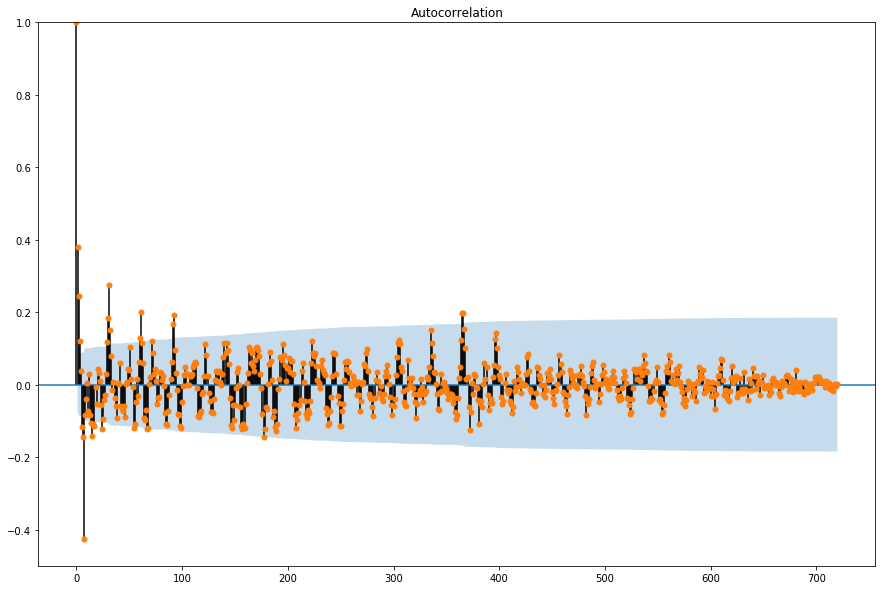

<Figure size 1080x720 with 0 Axes>

(-0.5, 1)

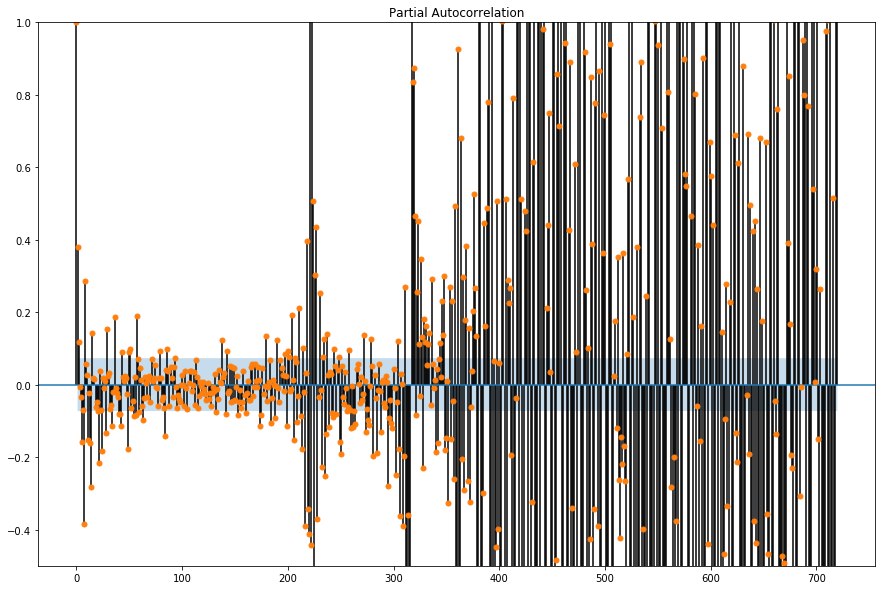

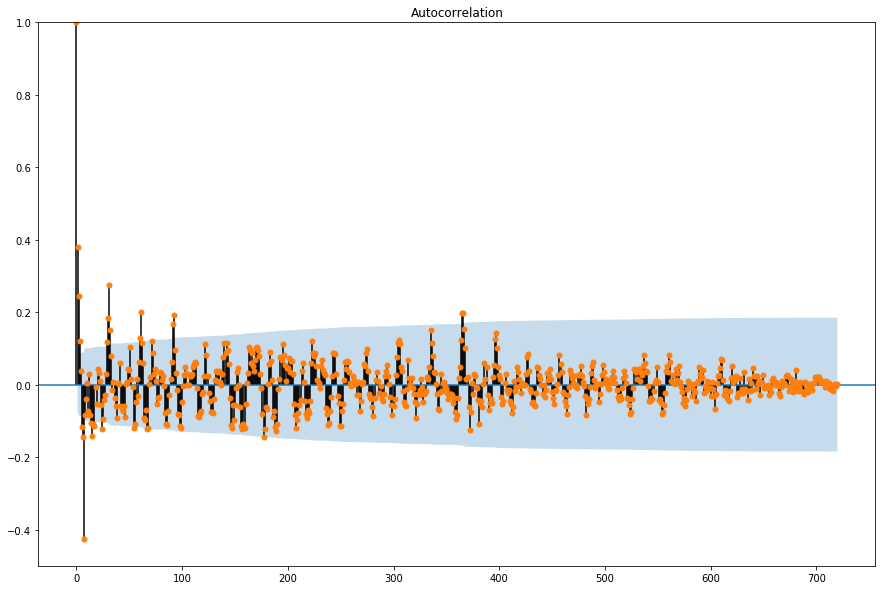

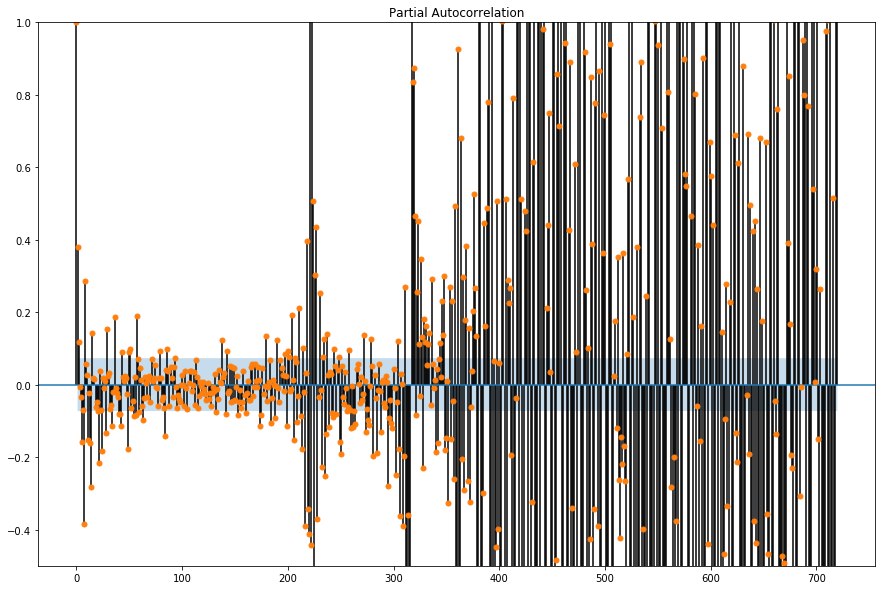

In [19]:
# ACF and PACF plots of time series
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
#stationary 1

pyplot.figure(6,figsize=(15,10)) 
pyplot.plot(211)
pylab.ylim([-0.5,1])
plot_acf(stationary1, ax=pyplot.gca()) 

pyplot.figure(7,figsize=(15,10)) 
pyplot.plot(212)
pylab.ylim([-0.5,1])
plot_pacf(stationary1, ax=pyplot.gca())


<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

In ACF and PACF, identifying lags will help determine ARIMA parameters. ARIMA is set at (3, 0, 1). The parameters result in an RMSE of 696, superior than in persistence model of RMSE 818. Building a better model may improve results. 

<br>
<br>
Word count: 41 
</div>

### 4.4 Running the ARIMA model

In [20]:
# evaluate manually configured ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Set series1 for the Global active power variable
df = pd.read_csv('train.csv',header=0);
df['log'] = pd.to_datetime(df['log'].astype(str))
series1 = pd.Series(df['Global_active_power'].values , index=df['log'])

# prepare data
X = series1.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # difference data
    days_in_week = 7
    diff = difference(history, days_in_week)
    
    # predict
    model = ARIMA(diff, order=(3,0,1)) #using manually selected parameters
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_in_week)
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=1713.844, Expected=2737
>Predicted=1790.888, Expected=2762
>Predicted=2407.634, Expected=1798
>Predicted=2135.398, Expected=2623
>Predicted=1336.565, Expected=2196
>Predicted=1736.839, Expected=1950
>Predicted=1735.415, Expected=1983
>Predicted=2359.117, Expected=2611
>Predicted=2346.746, Expected=2409
>Predicted=1326.645, Expected=2258
>Predicted=2332.967, Expected=2695
>Predicted=1980.465, Expected=2580
>Predicted=1720.100, Expected=2532
>Predicted=1852.136, Expected=3113
>Predicted=2621.046, Expected=3299
>Predicted=2360.309, Expected=2559
>Predicted=1932.675, Expected=2217
>Predicted=2206.399, Expected=2760
>Predicted=2102.595, Expected=1535
>Predicted=1824.553, Expected=1142
>Predicted=2168.321, Expected=2129
>Predicted=2515.391, Expected=576
>Predicted=1540.921, Expected=1849
>Predicted=1523.198, Expected=1215
>Predicted=2556.453, Expected=740
>Predicted=1080.554, Expected=1248
>Predicted=1037.439, Expected=1872
>Predicted=2722.639, Expected=830
>Predicted=818.751, Exp

>Predicted=1623.070, Expected=302
>Predicted=1070.542, Expected=1309
>Predicted=1469.372, Expected=1861
>Predicted=2278.410, Expected=1733
>Predicted=1706.771, Expected=1869
>Predicted=1263.797, Expected=283
>Predicted=784.858, Expected=270
>Predicted=-64.188, Expected=274
>Predicted=1326.309, Expected=275
>Predicted=1823.661, Expected=275
>Predicted=1398.920, Expected=274
>Predicted=1564.288, Expected=275
>Predicted=80.476, Expected=268
>Predicted=579.304, Expected=261
>Predicted=943.303, Expected=267
>Predicted=914.795, Expected=255
>Predicted=881.844, Expected=255
>Predicted=850.560, Expected=250
>Predicted=825.037, Expected=258
>Predicted=795.646, Expected=258
>Predicted=768.284, Expected=268
>Predicted=757.337, Expected=268
>Predicted=723.557, Expected=270
>Predicted=704.084, Expected=1503
>Predicted=1021.343, Expected=1788
>Predicted=1284.939, Expected=2102
>Predicted=1303.726, Expected=1560
>Predicted=1078.645, Expected=1219
>Predicted=741.575, Expected=1747
>Predicted=734.685, 

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

Running the ARIMA (3, 0, 1) model results in an RMSE of 683, which is better than the persistence RMSE of 752. This is a great start, but we may be able to improve the result by building a better model.
<br>
<br>
Word count: 41 
</div>

### 4.5 Review the residual errors

In [21]:
# summarize ARIMA forecast residuals
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# prepare data
X = series1.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()


for i in range(len(test)):
    # difference data
    days_in_weeks = 7
    diff = difference(history, days_in_weeks)
    
    # predict
    model = ARIMA(diff, order=(3,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_in_weeks)
    predictions.append(yhat)

    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())


                 0
count   364.000000
mean      0.502024
std     683.994062
min   -1939.376567
25%    -455.222718
50%      39.676341
75%     425.336966
max    2463.674825


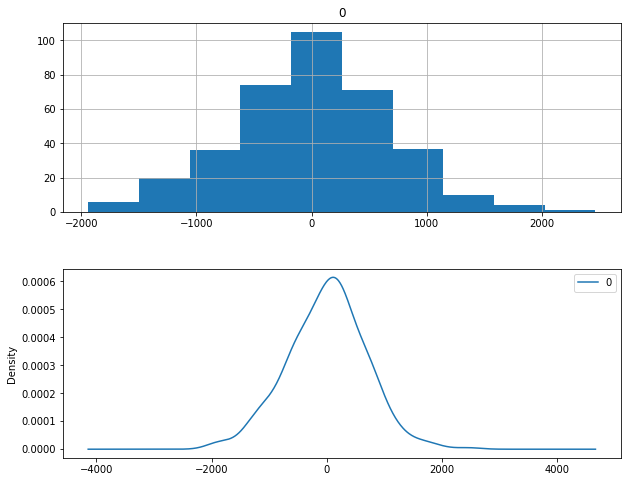

In [22]:
# plot
pyplot.figure(8,figsize=(10, 8))
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show();

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

In the second graph above, it shows the density plot of the residual error values. It suggests that the errors are Gaussian, however, it may not be centered on zero.
<br>
<br>
Word count: 30 
</div>

### 4.6 Grid search ARIMA model hyperparameters

In [23]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        days_in_weeks = 7
        diff = difference(history, days_in_weeks)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, days_in_weeks)
        predictions.append(yhat)
        history.append(test[i])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0,1, 3, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series1.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=783.472
ARIMA(0, 0, 1) RMSE=715.991
ARIMA(0, 0, 2) RMSE=706.042
ARIMA(0, 1, 0) RMSE=801.975
ARIMA(0, 1, 1) RMSE=747.420
ARIMA(0, 1, 2) RMSE=718.465
ARIMA(0, 2, 0) RMSE=1292.758
ARIMA(0, 2, 1) RMSE=803.998
ARIMA(1, 0, 0) RMSE=695.029
ARIMA(1, 0, 1) RMSE=692.927
ARIMA(1, 0, 2) RMSE=695.197
ARIMA(1, 1, 0) RMSE=769.826
ARIMA(1, 1, 1) RMSE=696.974
ARIMA(1, 1, 2) RMSE=694.841
ARIMA(1, 2, 0) RMSE=1075.107
ARIMA(1, 2, 1) RMSE=772.137
ARIMA(3, 0, 1) RMSE=684.442
ARIMA(3, 0, 2) RMSE=655.347
ARIMA(3, 1, 0) RMSE=751.474
ARIMA(3, 1, 1) RMSE=736.603
ARIMA(3, 1, 2) RMSE=695.266
ARIMA(3, 2, 0) RMSE=884.981
ARIMA(5, 0, 1) RMSE=684.518
ARIMA(5, 0, 2) RMSE=668.619
ARIMA(5, 1, 0) RMSE=748.483
ARIMA(5, 1, 1) RMSE=722.065
ARIMA(5, 1, 2) RMSE=675.684
ARIMA(5, 2, 0) RMSE=806.320
ARIMA(5, 2, 1) RMSE=781.024
Best ARIMA(3, 0, 2) RMSE=655.347


### 4.7 Review residual errors for final model 

In [15]:
# summarize ARIMA forecast residuals
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# prepare data
X = series1.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()


for i in range(len(test)):
    # difference data
    days_in_weeks = 7
    diff = difference(history, days_in_weeks)
    
    # predict
    model = ARIMA(diff, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_in_weeks)
    predictions.append(yhat)

    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

                 0
count   364.000000
mean     -4.364138
std     655.829031
min   -2506.024333
25%    -374.947088
50%       8.705915
75%     376.393903
max    2235.270289


In [ ]:
# plot
pyplot.figure(8,figsize=(10, 8))
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show();

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

Gridsearch suggests ARIMA (3, 0, 2). Compared to ARIMA (3, 0, 1), distribution is Gaussian and less bumpy. Mean remains non-zero but closer to 0. 

<br>
<br>
Word count: 25
</div>

### 4.8 Finalise model and make prediction

In [26]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# difference data
weeks_in_days = 7
diff = difference(X, weeks_in_days)

# fit model
model = ARIMA(diff, order=(3,0,2))
model_fit = model.fit(trend='nc', disp=0)

# save model
model_fit.save('model.pkl')

In [27]:
# load finalized model and make a prediction
# load finalized model and make a prediction

weeks_in_days = 7
model_fit = ARIMAResults.load('model.pkl') 
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(series1.values, yhat, weeks_in_days)
print('Predicted: %.3f' % yhat)

Predicted: 1232.499


### 4.9 Final model on validation set

In [28]:
# load and evaluate the finalized model on the validation dataset

# load and prepare datasets
history = [x for x in X]
days_in_weeks = 7

# load data
df = pd.read_csv('train.csv',header=0);
df['log'] = pd.to_datetime(df['log'].astype(str))
train = pd.Series(df['Global_active_power'].values , index=df['log'])


# load data
# Set series1 for the Global active power variable
df = pd.read_csv('test.csv',header=0);
df['log'] = pd.to_datetime(df['log'].astype(str))
validation = pd.Series(df['Global_active_power'].values , index=df['log'])
prediction = validation #creat dummy series to hold prediction data

x = train.values.astype('float32')
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, days_in_weeks)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # difference data
    days_in_weeks = 7
    diff = difference(history, days_in_weeks)
    
    # predict
    model = ARIMA(diff, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, days_in_weeks)
    predictions.append(yhat)
    
    # observation
    obs = y[i]
    history.append(obs)
    
    prediction[i] = yhat    
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)


>Predicted=1232.499, Expected=1826
>Predicted=1363.452, Expected=2002
>Predicted=883.646, Expected=1795
>Predicted=2113.666, Expected=1797
>Predicted=1993.931, Expected=2099
>Predicted=2060.035, Expected=1737
>Predicted=1799.800, Expected=1882
>Predicted=1830.296, Expected=2244
>Predicted=2095.713, Expected=2644
>Predicted=2201.364, Expected=2016
>Predicted=1999.909, Expected=1798
>Predicted=1861.178, Expected=1270
>Predicted=1376.273, Expected=1061
>Predicted=1644.093, Expected=1224
>Predicted=1947.318, Expected=2972
>Predicted=2827.804, Expected=1571
>Predicted=1985.827, Expected=555
>Predicted=762.935, Expected=1195
>Predicted=612.509, Expected=1964
>Predicted=2017.551, Expected=1407
>Predicted=1737.019, Expected=1828
>Predicted=2354.208, Expected=2473
>Predicted=1495.777, Expected=1641
>Predicted=1156.111, Expected=1513
>Predicted=1277.230, Expected=1443
>Predicted=1865.304, Expected=1218
>Predicted=1427.604, Expected=707
>Predicted=1675.096, Expected=981
>Predicted=1831.743, Expec

>Predicted=997.241, Expected=1234
>Predicted=1561.767, Expected=526
>Predicted=1486.768, Expected=1086
>Predicted=1470.919, Expected=1577
>Predicted=770.411, Expected=2508
>Predicted=1803.294, Expected=2007
>Predicted=1634.891, Expected=806
>Predicted=1989.435, Expected=749
>Predicted=969.204, Expected=1514
>Predicted=1069.473, Expected=1218
>Predicted=935.129, Expected=786
>Predicted=1779.894, Expected=1081
>Predicted=1523.420, Expected=881
>Predicted=601.975, Expected=776
>Predicted=712.789, Expected=1162
>Predicted=1483.324, Expected=1549
>Predicted=1177.983, Expected=1067
>Predicted=833.549, Expected=1252
>Predicted=1307.377, Expected=944
>Predicted=1005.089, Expected=1137
>Predicted=889.685, Expected=749
>Predicted=1117.915, Expected=1119
>Predicted=1437.437, Expected=1388
>Predicted=933.293, Expected=1668
>Predicted=1339.441, Expected=1266
>Predicted=1092.409, Expected=1789
>Predicted=1572.931, Expected=1707
>Predicted=1206.278, Expected=1686
>Predicted=1622.962, Expected=1890
>P

>Predicted=1977.171, Expected=1924
>Predicted=1778.732, Expected=1604
>Predicted=1801.000, Expected=2316
>Predicted=2055.767, Expected=683
>Predicted=1612.842, Expected=1690
>Predicted=1398.618, Expected=1517
>Predicted=1515.523, Expected=1421
>Predicted=1543.099, Expected=1538
>Predicted=1449.265, Expected=543
>Predicted=2197.055, Expected=1744
>Predicted=547.051, Expected=1776
>Predicted=1635.533, Expected=2555
>Predicted=1548.892, Expected=  0
>Predicted=1423.373, Expected=1513
>Predicted=1841.354, Expected=1660
>Predicted=562.516, Expected=1872
>Predicted=1740.113, Expected=1562
>Predicted=1661.504, Expected=1558
>Predicted=2712.750, Expected=1476
>Predicted=66.778, Expected=1709
>Predicted=1783.855, Expected=1834
>Predicted=1624.109, Expected=1580
>Predicted=1939.719, Expected=1461
>Predicted=1689.935, Expected=1181
>Predicted=1579.776, Expected=1518
>Predicted=1288.963, Expected=1543
>Predicted=1375.641, Expected=1083
>Predicted=1471.537, Expected=1251
>Predicted=1403.138, Expect

>Predicted=1588.274, Expected=1578
>Predicted=1617.513, Expected=1796
>Predicted=1731.012, Expected=1431
>Predicted=1592.280, Expected=1488
>Predicted=2203.911, Expected=  0
>Predicted=412.238, Expected=  0
>Predicted=1406.609, Expected=  0
>Predicted=363.676, Expected=  0
>Predicted=533.678, Expected=2191
>Predicted=734.981, Expected=1893
>Predicted=1517.679, Expected=1645
>Predicted=821.982, Expected=1439
>Predicted=1382.213, Expected=2035
>Predicted=1217.212, Expected=1974
>Predicted=741.444, Expected=1110
>Predicted=2500.243, Expected=530
>Predicted=1657.926, Expected=1612
>Predicted=1415.429, Expected=1580
>Predicted=959.685, Expected=1837
RMSE: 671.971


<Figure size 720x576 with 0 Axes>

Text(0.5, 0.01, 'The train, test and predictive time series comparison')

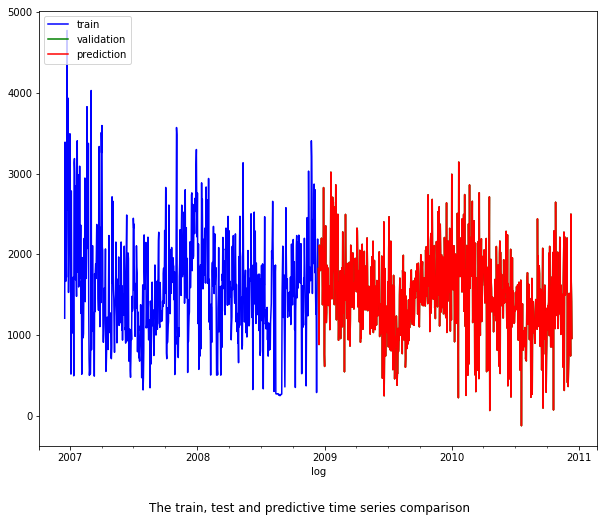

In [29]:
pyplot.figure(9,figsize=(10, 8))
train.plot(color='blue',label='train')
validation.plot(color='green',label='validation')
prediction.plot(color='red',label='prediction')
txt="The train, test and predictive time series comparison"
pyplot.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
pyplot.legend(loc='upper left')
pyplot.show()

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

One observation is that the RMSE for testing set is higher than the training set. We can vizualise this results by plotting the train, test and predictive time series together on the same graph.
<br>
<br>
Word count: 34
</div>

### 4.10 GARCH model
- motivations: GARCH - allows the method to support changes in the time dependent volatility, such as increasing and decreasing volatility in the same series

In [30]:
from arch import arch_model
# Working with data
values = d.values

# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])

# ensure all data is float
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
d1 = pd.DataFrame(scaler.fit_transform(values))
d1 = d1.set_index(d.index)
d1.columns = [i for i in d.columns]

#d1.drop([], )

In [31]:
def evaluate_modelgarch(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, maxlag=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results


In [32]:
def gridsearchgarch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_modelgarch(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score: 
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models


In [33]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()


In [34]:
def garchmodel(data, splits, series_column):
    plt.plot(d1[series_column])
    plt.title(series_column)
    plt.show()
    # Spliting the data
    split = int(splits * len(data)) #Note: change the split for the faster model training
    train, test = data[series_column][:split], data[series_column][split:]
    
    #do gridsearch
    p_rng = range(0,10)
    q_rng = range(0,10)
    top_models = gridsearchgarch(train, p_rng, q_rng)
    top_models

    # design garch
    garch = arch_model(train, vol='GARCH', p=top_models[0]['params']['p'], q=top_models[0]['params']['q'], dist='normal')
    fgarch = garch.fit(disp='off') 

    resid = fgarch.resid
    st_resid = np.divide(resid, fgarch.conditional_volatility)

    #model results
    print(fgarch.summary())
    arch_test = het_arch(resid, maxlag=50)
    shapiro_test = shapiro(st_resid)
    print(f'Lagrange mulitplier p-value: {arch_test[1]}')
    print(f'F test p-value: {arch_test[3]}')
    print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')
    ts_plot(resid, st_resid)
  

In [ ]:
#in the 3 hours before the submition the problem with arch_model from the package arch occured
#due to the time constrain we could not deal with the problem
#besides the results were already achived

#to check the results obtained go to GARCH-result Jupyter Nootbook

for i in d.columns[:7]:
    garchmodel(d1, 0.5, i )

In [ ]:
#Note:
# - omega -
# - alfa - 22.1% of the pervious periods volatility will be passed to the next day.
# - beta <1 no leading to a postive feedback loop for small shocks that can create runaway volatility.
# if alfa + beta =1, model has persistent volatility and we might want to look at other models like IGARCH.

# - p value is <0.05, so coeffisient has an effect

# check if the model has model has captured the conditional heteroskedasticity of our time series:
# - Lagrange multiplier test - residuals not exibit heterostedasity
# - F-test - Data  normaly distributed (for n<2000)
# - Sharpiro-Wilks - data normaly distributed


<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

The GARCH models have passed our Engel ARCH test and the standardized residuals appear approximately normal. However, it is has to capture the voliatility and all these model seak more  precice consideration
<br>
<br>
Word count: 32
</div>

<br>
<div class="alert alert-warning">
<b>5. ASSESSMENT (~200 words) ---> For this section, please see the blue boxes above! </b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

## 5. Supervised Learning formulation

### Feature engineering
***supevised setup, conceptualisation***

In [40]:
# add the dail average temperature (i think it is farenheit?) to the data
climate = pd.read_csv("climate_data.csv")
climate = climate.loc[climate.STATION == 'FR000007150'].iloc[15:1472,:]
d['climate'] = list(climate.iloc[:,3])
climate.shape, d.shape
# add weekend indicator
days = list(d.index.weekday)
weekend = [1 if (j==5 or j ==6) else 0 for j in days]
d['weekend'] = weekend

((1457, 4), (1457, 8))

In [41]:
len(climate.iloc[:,3])

1457

In [42]:
nlist = list()
for col in climate.columns:
    nlist.append(len([i for i in climate[col].isnull() if i==True])/climate.shape[0])
labels = [i for i in climate.columns]
print(nlist)
print(labels)

[0.0, 0.0, 0.0, 0.0]
['STATION', 'NAME', 'DATE', 'TAVG']


In [43]:
#Important for technical understanding!

# This is a "multivariate multi-step time series forecasting problem" in a supervised framework

# Using the lag method to create supervised learning dataset -> here 7 time lags are used
# Therefore we are in t0 and we predict the values t+1...t+7 (like Mo-Sun) based on t-7...t0 and the corresponding # moving window stats
# Incorporated time stamp features (seasonality, weekend etc..)
# Incorporated Paris weather data (temperatures) because the the measurements were taken in a place 7 miles from # Paris (temperature might add variation that can help explain the consumption, e.g. cold and rainy day vs. sunny and # warm)


### Re-framing the problem to make it a supervised one ###
#The issue is that we have multiple inputs as usual) but also multiple outputs (Global active power in future 7 # periods)!  Normal models cannot learn that, they only yield one output value. We need to re-frame the problem:

# TWO APPROACHES:
# 1) Direct multi-step approach: Build 7 classifiers, each classifies one day (all 7 based on the same data)
# 2) Recursive multi-step approach: One-step model predicts based on window and previous forecast step, 
# e.g. today == Sunday, preciction(Tuesday) is a function of window history, window statistics AND # prediction(Monday)

#  The second seems more promising. We implement the direct approach first and see whether we have time left.


cols = ['Global_active_power', 'Global_reactive_power','Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3','climate','weekend']
df_sup_all = pd.DataFrame()
for k in cols:
        temps = d[k]
        df_sup = pd.concat([temps.shift(7)-temps.shift(14),temps.shift(14),temps.shift(13),temps.shift(12),temps.shift(11),temps.shift(10),temps.shift(9),temps.shift(8),temps.shift(7),temps.shift(6),temps.shift(5),temps.shift(4),temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
        df_sup.columns = [k+'_'+'m_change',k+'_'+'t-7', k+'_'+'t-6' ,k+'_'+'t-5' ,k+'_'+'t-4' ,k+'_'+'t-3' ,k+'_'+'t-2' ,k+'_'+'t-1' ,k+'_'+ 't-0', k+'_'+'t+1', k+'_'+'t+2', k+'_'+'t+3', k+'_'+'t+4', k+'_'+'t+5', k+'_'+'t+6',k+'_'+ 't+7']
        m_mean = np.mean(df_sup.iloc[:,:-1], axis = 1)
        m_min = np.min(df_sup.iloc[:,:-1], axis = 1)
        m_max = np.max(df_sup.iloc[:,:-1], axis = 1)
        m_std = np.std(df_sup.iloc[:,:-1], axis = 1)
        df_sup.insert(loc=0, column = k+'_'+'m_mean', value = m_mean)
        df_sup.insert(loc=0, column = k+'_'+'m_min', value = m_min)
        df_sup.insert(loc=0, column = k+'_'+'m_max', value = m_max)
        df_sup.insert(loc=0, column = k+'_'+'m_std', value = m_std)
        df_sup_all = pd.concat([df_sup_all,df_sup], axis = 1)
        
# delete the first 14 rows due to the time lags! 
df_sup_all = df_sup_all.iloc[14:,:]

# note: the test, train split from earlier must be incorporated again, since this is the full dataset

In [44]:
# 1443 days to forecast (t+1...t+7 or equivalent to Monday to Sunday), 140 features generated plus some climate features
df_sup_all.shape

(1443, 180)

In [45]:
# the matriix contains 4 sliding window statistics and the 7 days previous days, and the 7 follwoing days that we need to predict (7 outcomes)
df_sup_all.head(3)

Global_active_power_m_std  Global_active_power_m_max  \
log                                                                
2006-12-30                 958.671436                   4773.386   
2006-12-31                1219.488569                   4773.386   
2007-01-01                1009.379152                   4773.386   

            Global_active_power_m_min  Global_active_power_m_mean  \
log                                                                 
2006-12-30                   1209.176                 2606.298800   
2006-12-31                   -840.448                 2418.825733   
2007-01-01                    539.294                 2517.724267   

            Global_active_power_m_change  Global_active_power_t-7  \
log                                                                 
2006-12-30                      3564.210                 1209.176   
2006-12-31                      -840.448                 3390.460   
2007-01-01                       539.294                 2203.826   

            Global_active_power_t-6  Global_active_power_t-5  \
log                                                            
2006-12-30                 3390.460                 2203.826   
2006-12-31                 2203.826                 1666.194   
2007-01-01                 1666.194                 2225.748   

            Global_active_power_t-4  Global_active_power_t-3  \
log                                                            
2006-12-30                 1666.194                 2225.748   
2006-12-31                 2225.748                 1717.112   
2007-01-01                 1717.112                 2341.338   

            Global_active_power_t-2  Global_active_power_t-1  \
log                                                            
2006-12-30                 1717.112                 2341.338   
2006-12-31                 2341.338                 4773.386   
2007-01-01                 4773.386                 2550.012   

            Global_active_power_t-0  Global_active_power_t+1  \
log                                                            
2006-12-30                 4773.386                 2550.012   
2006-12-31                 2550.012                 2743.120   
2007-01-01                 2743.120                 3934.110   

            Global_active_power_t+2  Global_active_power_t+3  \
log                                                            
2006-12-30                  2743.12                 3934.110   
2006-12-31                  3934.11                 1528.760   
2007-01-01                  1528.76                 2072.638   

            Global_active_power_t+4  Global_active_power_t+5  \
log                                                            
2006-12-30                 1528.760                 2072.638   
2006-12-31                 2072.638                 3174.392   
2007-01-01                 3174.392                 2801.738   

            Global_active_power_t+6  Global_active_power_t+7  \
log                                                            
2006-12-30                 3174.392                 2801.738   
2006-12-31                 2801.738                 3494.196   
2007-01-01                 3494.196                 2749.004   

            Global_reactive_power_m_std  Global_reactive_power_m_max  \
log                                                                    
2006-12-30                    48.352982                      270.608   
2006-12-31                    77.732548                      335.876   
2007-01-01                    51.823849                      335.876   

            Global_reactive_power_m_min  Global_reactive_power_m_mean  \
log                                                                     
2006-12-30                       44.942                    205.737467   
2006-12-31                      -49.110                    209.253867   
2007-01-01                       76.082                    215.150800   

     

### Supervised modelling, base classifiers
***Direct approach to multistep time series***

In [46]:
# Create a direct modelling approach
data = df_sup_all.iloc[:,13:20]
temp_df = pd.concat([df_sup_all.iloc[:,0:13], df_sup_all.iloc[:,20:33],df_sup_all.iloc[:,40:53],df_sup_all.iloc[:,60:73],df_sup_all.iloc[:,80:93],df_sup_all.iloc[:,100:113],df_sup_all.iloc[:,120:133],df_sup_all.iloc[:,140:153],df_sup_all.iloc[:,160:173]],axis = 1)
df_direct = pd.concat([temp_df,data],axis = 1)
df_direct.shape
df_direct_fp = df_direct

(1443, 124)

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_direct = scaler.fit_transform(df_direct)
df_direct = pd.DataFrame(df_direct)
n_train = int(0.5 * len(d))
train_X = df_direct.iloc[:n_train,:117]
train_y = df_direct.iloc[:n_train,117:]
test_X = df_direct.iloc[n_train:,:117]
test_y = df_direct.iloc[n_train:,117:]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((728, 117), (728, 7), (715, 117), (715, 7))

In [48]:
# copy for the polynomial regression only
df_direct_fp.shape

(1443, 124)

<div class="alert alert-info">
    <b>SECTION COMPREHENSION</b>
    <br>
Data is normalised by using a scaler. Features are in range 0 to 1 from this point and used in train and test subsets. 
<br>
<br>
Word count: 24

### Linear Regression

RMSE t+1: 7367.749887039318
RMSE t+2: 6476.051326189706
RMSE t+3: 26293.136937325526
RMSE t+4: 16996.09384397808
RMSE t+5: 17820.266842714253
RMSE t+6: 24621.0633963857
RMSE t+7: 2468.317188352645
Overall Test RMSE: 14577.526


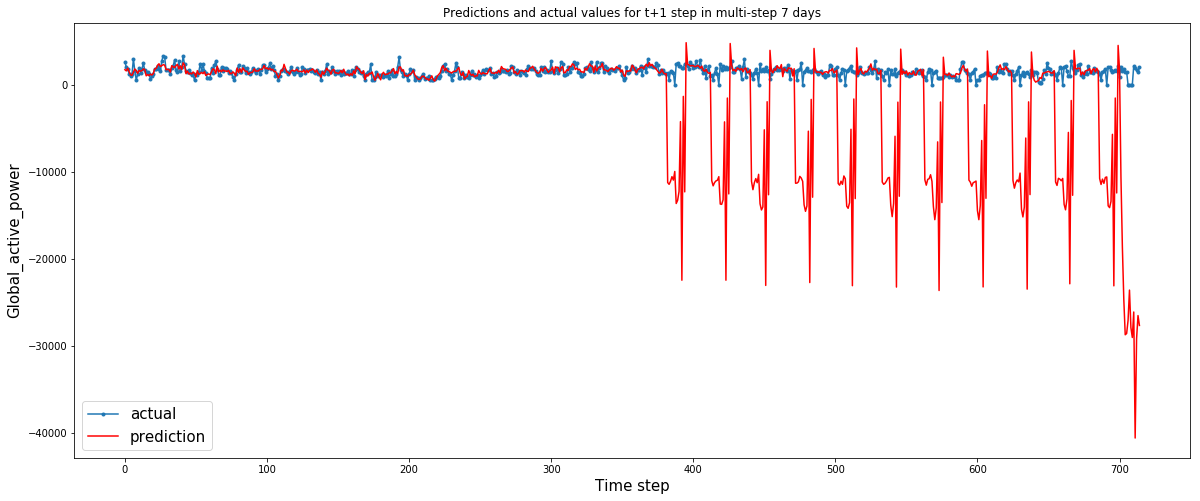

In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
reg_t_1 = LinearRegression().fit(train_X, train_y.iloc[:,0])
reg_t_2 = LinearRegression().fit(train_X, train_y.iloc[:,1])
reg_t_3 = LinearRegression().fit(train_X, train_y.iloc[:,2])
reg_t_4 = LinearRegression().fit(train_X, train_y.iloc[:,3])
reg_t_5 = LinearRegression().fit(train_X, train_y.iloc[:,4])
reg_t_6 = LinearRegression().fit(train_X, train_y.iloc[:,5])
reg_t_7 = LinearRegression().fit(train_X, train_y.iloc[:,6])

reg_t_1_pred = pd.Series(reg_t_1.predict(test_X))
reg_t_2_pred = pd.Series(reg_t_2.predict(test_X))
reg_t_3_pred = pd.Series(reg_t_3.predict(test_X))
reg_t_4_pred = pd.Series(reg_t_4.predict(test_X))
reg_t_5_pred = pd.Series(reg_t_5.predict(test_X))
reg_t_6_pred = pd.Series(reg_t_6.predict(test_X))
reg_t_7_pred = pd.Series(reg_t_7.predict(test_X))

#from sklearn.metrics import mean_squared_error
#rmse = sqrt(mean_squared_error(test_y.iloc[:,0],reg_t_1_pred))
#print(rmse)


# invert scaling:
# matrix of predicted values with shape of test_y
yhat = pd.concat([reg_t_1_pred,reg_t_2_pred,reg_t_3_pred,reg_t_4_pred,reg_t_5_pred,reg_t_6_pred,reg_t_7_pred],axis = 1)

inv_yhat = np.concatenate((test_X ,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = pd.DataFrame(inv_yhat).iloc[:,117:]

inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,117:]

# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

inter = [x for x in range(inv_y.shape[0])]
plt.figure(figsize = (20,8))
plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step in multi-step 7 days')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

<div class="alert alert-info">
    <b>MODEL COMPREHENSION</b>
    <br>
Linear regression is applied with direct approach, however resulting in high levels of RMSE. It is inferred that around time step 400, variation of predictions drastically increase. 

<br>
<br>
Word count: 27

### Decision Tree

In [50]:
from sklearn.tree import DecisionTreeRegressor
clf_d = DecisionTreeRegressor()

tree_t_1 = clf_d.fit(train_X, train_y.iloc[:,0])
tree_t_2 = clf_d.fit(train_X, train_y.iloc[:,1])
tree_t_3 = clf_d.fit(train_X, train_y.iloc[:,2])
tree_t_4 = clf_d.fit(train_X, train_y.iloc[:,3])
tree_t_5 = clf_d.fit(train_X, train_y.iloc[:,4])
tree_t_6 = clf_d.fit(train_X, train_y.iloc[:,5])
tree_t_7 = clf_d.fit(train_X, train_y.iloc[:,6])

tree_t_1_pred = pd.Series(tree_t_1.predict(test_X))
tree_t_3_pred = pd.Series(tree_t_3.predict(test_X))
tree_t_4_pred = pd.Series(tree_t_4.predict(test_X))
tree_t_5_pred = pd.Series(tree_t_5.predict(test_X))
tree_t_6_pred = pd.Series(tree_t_6.predict(test_X))
tree_t_7_pred = pd.Series(tree_t_7.predict(test_X))


#rmse_tree = sqrt(mean_squared_error(test_y.iloc[:,0],tree_t_1_pred))
#print(rmse_tree)

tree_t_1_pred = pd.Series(tree_t_1.predict(test_X))
tree_t_2_pred = pd.Series(tree_t_2.predict(test_X))
tree_t_3_pred = pd.Series(tree_t_3.predict(test_X))
tree_t_4_pred = pd.Series(tree_t_4.predict(test_X))
tree_t_5_pred = pd.Series(tree_t_5.predict(test_X))
tree_t_6_pred = pd.Series(tree_t_6.predict(test_X))
tree_t_7_pred = pd.Series(tree_t_7.predict(test_X))

yhat_d = pd.concat([tree_t_1_pred,tree_t_2_pred,tree_t_3_pred,tree_t_4_pred,tree_t_5_pred,tree_t_6_pred,tree_t_7_pred],axis = 1)

inv_yhat_d = np.concatenate((test_X ,yhat_d), axis=1)
inv_yhat_d = scaler.inverse_transform(inv_yhat_d)
inv_yhat_d = pd.DataFrame(inv_yhat_d).iloc[:,117:]

inv_y_d = np.concatenate((test_X, test_y), axis=1)
inv_y_d = scaler.inverse_transform(inv_y_d)
inv_y_d = pd.DataFrame(inv_y_d).iloc[:,117:]

# RMSE and combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y_d.iloc[:,k], inv_yhat_d.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y_d.iloc[:,k], inv_yhat_d.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

RMSE t+1: 956.76305881748
RMSE t+2: 997.5584531886902
RMSE t+3: 994.0189294158126
RMSE t+4: 977.5544429796366
RMSE t+5: 977.226233115741
RMSE t+6: 975.4561192894873
RMSE t+7: 972.21161863811
Overall Test RMSE: 978.684


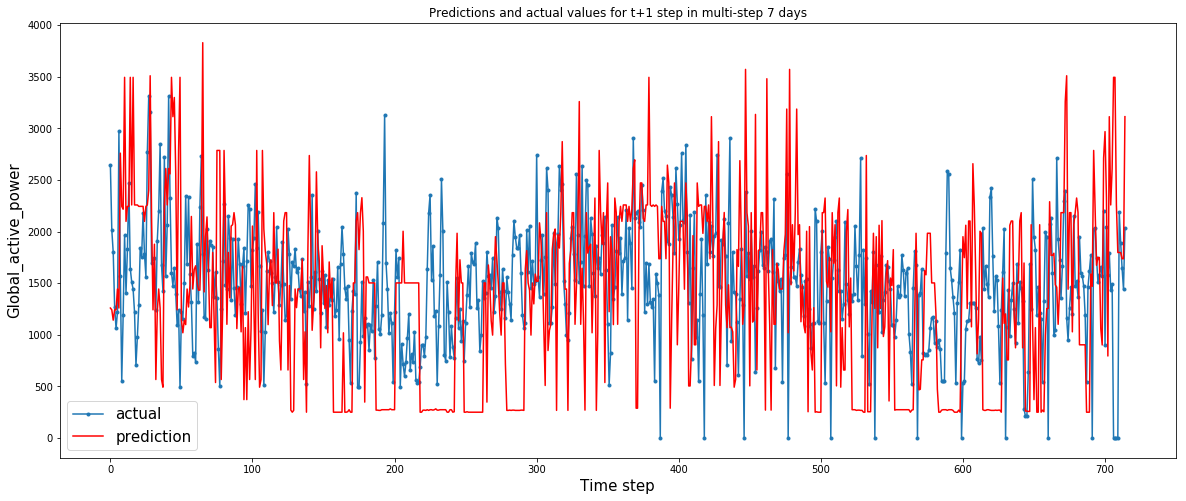

In [51]:
inter = [x for x in range(inv_y_d.shape[0])]
plt.figure(figsize = (20,8))
plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(inter, inv_yhat_d.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step in multi-step 7 days')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

<div class="alert alert-info">
    <b>MODEL COMPREHENSION</b>
    <br>
A non-linear decision tree is deployed to test a second supervised algorithm. An RMSE of 957 shows improved performance compared to linear regression, with less variation. 
<br>
<br>
Word count: 26

### Polynomial

In [52]:
# Polynomial transformation before splitting into train and test
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=2)
train_temp = df_direct_fp.iloc[:,:117]
test_temp = df_direct_fp.iloc[:,117:]
train_temp_poly = pd.DataFrame(polynomial_features.fit_transform(train_temp))
test_temp.reset_index(drop=True, inplace=True)
train_temp_poly.reset_index(drop=True, inplace=True)
df_direct_poly = pd.concat([train_temp_poly,test_temp],axis = 1)
df_direct_poly.shape
scaler = MinMaxScaler(feature_range=(0, 1))
df_direct_poly = scaler.fit_transform(df_direct_poly)
df_direct_poly = pd.DataFrame(df_direct_poly)
n_train = int(0.5 * len(d))
train_X_p = df_direct_poly.iloc[:n_train,:7021]
train_y_p = df_direct_poly.iloc[:n_train,7021:]
test_X_p = df_direct_poly.iloc[n_train:,:7021]
test_y_p = df_direct_poly.iloc[n_train:,7021:]
train_X_p.shape, train_y_p.shape, test_X_p.shape, test_y_p.shape

(1443, 7028)

((728, 7021), (728, 7), (715, 7021), (715, 7))

In [53]:
# Linear regression with polynominal features

rpoly_t_1 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,0])
rpoly_t_2 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,1])
rpoly_t_3 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,2])
rpoly_t_4 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,3])
rpoly_t_5 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,4])
rpoly_t_6 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,5])
rpoly_t_7 = LinearRegression().fit(train_X_p, train_y_p.iloc[:,6])

#from sklearn.metrics import mean_squared_error
#rmse = sqrt(mean_squared_error(test_y_p.iloc[:,0],rpoly_t_1_pred))
#print(rmse)

rpoly_t_1_pred = pd.Series(rpoly_t_1.predict(test_X_p))
rpoly_t_2_pred = pd.Series(rpoly_t_2.predict(test_X_p))
rpoly_t_3_pred = pd.Series(rpoly_t_3.predict(test_X_p))
rpoly_t_4_pred = pd.Series(rpoly_t_4.predict(test_X_p))
rpoly_t_5_pred = pd.Series(rpoly_t_5.predict(test_X_p))
rpoly_t_6_pred = pd.Series(rpoly_t_6.predict(test_X_p))
rpoly_t_7_pred = pd.Series(rpoly_t_7.predict(test_X_p))

yhat = pd.concat([rpoly_t_1_pred,rpoly_t_2_pred,rpoly_t_3_pred,rpoly_t_4_pred,rpoly_t_5_pred,rpoly_t_6_pred,rpoly_t_7_pred],axis = 1)

inv_yhat_p = np.concatenate((test_X_p ,yhat), axis=1)
inv_yhat_p = scaler.inverse_transform(inv_yhat_p)
inv_yhat_p = pd.DataFrame(inv_yhat_p).iloc[:,7021:]

inv_y = np.concatenate((test_X_p, test_y_p), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,7021:]

# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)
# over-fitting -> rugularisation needed

RMSE t+1: 920.5232598759753
RMSE t+2: 1039.9481631821093
RMSE t+3: 845.8806100204943
RMSE t+4: 900.6659898633261
RMSE t+5: 815.7522553036385
RMSE t+6: 1125.9648540701917
RMSE t+7: 1284.9452459026934
Overall Test RMSE: 990.526


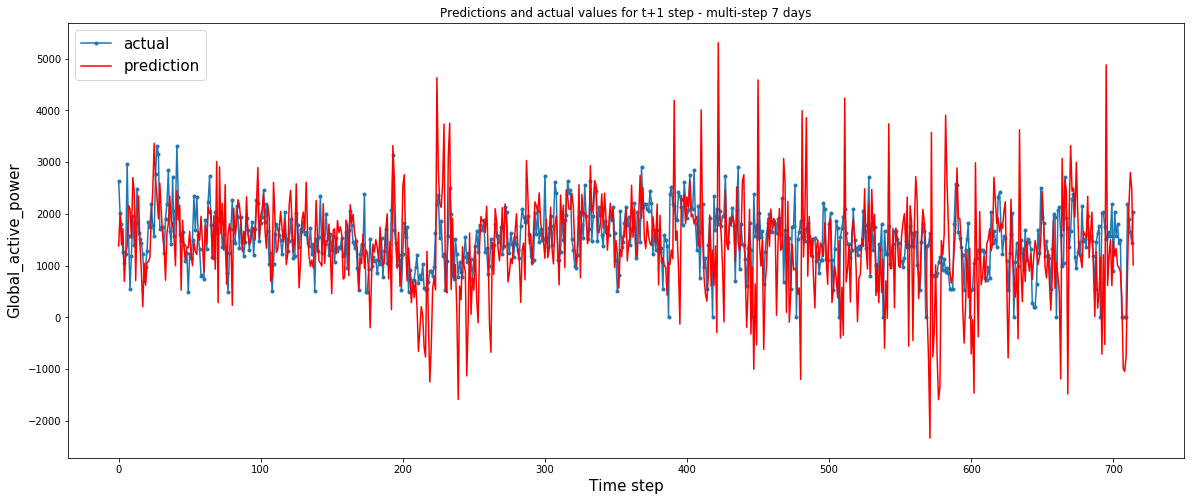

In [54]:
intertree = [x for x in range(inv_y_d.shape[0])]
plt.figure(figsize = (20,8))
plt.plot(intertree, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(intertree, inv_yhat_p.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - multi-step 7 days')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [55]:
# Ridge regression with polynominal features
from sklearn.linear_model import Ridge
ridgereg_1 = Ridge(alpha = 1.0)
rpoly_t_1 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,0])
rpoly_t_2 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,1])
rpoly_t_3 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,2])
rpoly_t_4 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,3])
rpoly_t_5 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,4])
rpoly_t_6 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,5])
rpoly_t_7 = ridgereg_1.fit(train_X_p, train_y_p.iloc[:,6])

#from sklearn.metrics import mean_squared_error
#rmse = sqrt(mean_squared_error(test_y_p.iloc[:,0],rpoly_t_1_pred))
#print(rmse)

rpoly_t_1_pred = pd.Series(rpoly_t_1.predict(test_X_p))
rpoly_t_2_pred = pd.Series(rpoly_t_2.predict(test_X_p))
rpoly_t_3_pred = pd.Series(rpoly_t_3.predict(test_X_p))
rpoly_t_4_pred = pd.Series(rpoly_t_4.predict(test_X_p))
rpoly_t_5_pred = pd.Series(rpoly_t_5.predict(test_X_p))
rpoly_t_6_pred = pd.Series(rpoly_t_6.predict(test_X_p))
rpoly_t_7_pred = pd.Series(rpoly_t_7.predict(test_X_p))

yhat = pd.concat([rpoly_t_1_pred,rpoly_t_2_pred,rpoly_t_3_pred,rpoly_t_4_pred,rpoly_t_5_pred,rpoly_t_6_pred,rpoly_t_7_pred],axis = 1)

inv_yhat_p = np.concatenate((test_X_p ,yhat), axis=1)
inv_yhat_p = scaler.inverse_transform(inv_yhat_p)
inv_yhat_p = pd.DataFrame(inv_yhat_p).iloc[:,7021:]

inv_y = np.concatenate((test_X_p, test_y_p), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,7021:]

# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

RMSE t+1: 943.2641575018145
RMSE t+2: 955.1379559578902
RMSE t+3: 933.3092157193402
RMSE t+4: 907.5639509211908
RMSE t+5: 902.3665215924775
RMSE t+6: 865.6819397063355
RMSE t+7: 853.6030467213151
Overall Test RMSE: 908.704


In [56]:
# Ridge with alpha = 0.5
ridgereg_0_5 = Ridge(alpha = 0.5)
rpoly_t_1 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,0])
rpoly_t_2 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,1])
rpoly_t_3 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,2])
rpoly_t_4 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,3])
rpoly_t_5 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,4])
rpoly_t_6 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,5])
rpoly_t_7 = ridgereg_0_5.fit(train_X_p, train_y_p.iloc[:,6])

#from sklearn.metrics import mean_squared_error
#rmse = sqrt(mean_squared_error(test_y_p.iloc[:,0],rpoly_t_1_pred))
#print(rmse)

rpoly_t_1_pred = pd.Series(rpoly_t_1.predict(test_X_p))
rpoly_t_2_pred = pd.Series(rpoly_t_2.predict(test_X_p))
rpoly_t_3_pred = pd.Series(rpoly_t_3.predict(test_X_p))
rpoly_t_4_pred = pd.Series(rpoly_t_4.predict(test_X_p))
rpoly_t_5_pred = pd.Series(rpoly_t_5.predict(test_X_p))
rpoly_t_6_pred = pd.Series(rpoly_t_6.predict(test_X_p))
rpoly_t_7_pred = pd.Series(rpoly_t_7.predict(test_X_p))

yhat = pd.concat([rpoly_t_1_pred,rpoly_t_2_pred,rpoly_t_3_pred,rpoly_t_4_pred,rpoly_t_5_pred,rpoly_t_6_pred,rpoly_t_7_pred],axis = 1)

inv_yhat_p = np.concatenate((test_X_p ,yhat), axis=1)
inv_yhat_p = scaler.inverse_transform(inv_yhat_p)
inv_yhat_p = pd.DataFrame(inv_yhat_p).iloc[:,7021:]

inv_y = np.concatenate((test_X_p, test_y_p), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,7021:]

# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

RMSE t+1: 1048.847852230668
RMSE t+2: 1061.9656816952747
RMSE t+3: 1039.5940829317428
RMSE t+4: 1013.3879051126942
RMSE t+5: 1007.0216804144266
RMSE t+6: 970.4367626552929
RMSE t+7: 954.2527609555674
Overall Test RMSE: 1013.644


In [57]:
# Ridge with alpha = 0.1
ridgereg_0_1 = Ridge(alpha = 0.1)
rpoly_t_1 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,0])
rpoly_t_2 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,1])
rpoly_t_3 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,2])
rpoly_t_4 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,3])
rpoly_t_5 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,4])
rpoly_t_6 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,5])
rpoly_t_7 = ridgereg_0_1.fit(train_X_p, train_y_p.iloc[:,6])

#from sklearn.metrics import mean_squared_error
#rmse = sqrt(mean_squared_error(test_y_p.iloc[:,0],rpoly_t_1_pred))
#print(rmse)

rpoly_t_1_pred = pd.Series(rpoly_t_1.predict(test_X_p))
rpoly_t_2_pred = pd.Series(rpoly_t_2.predict(test_X_p))
rpoly_t_3_pred = pd.Series(rpoly_t_3.predict(test_X_p))
rpoly_t_4_pred = pd.Series(rpoly_t_4.predict(test_X_p))
rpoly_t_5_pred = pd.Series(rpoly_t_5.predict(test_X_p))
rpoly_t_6_pred = pd.Series(rpoly_t_6.predict(test_X_p))
rpoly_t_7_pred = pd.Series(rpoly_t_7.predict(test_X_p))

yhat = pd.concat([rpoly_t_1_pred,rpoly_t_2_pred,rpoly_t_3_pred,rpoly_t_4_pred,rpoly_t_5_pred,rpoly_t_6_pred,rpoly_t_7_pred],axis = 1)

inv_yhat_p = np.concatenate((test_X_p ,yhat), axis=1)
inv_yhat_p = scaler.inverse_transform(inv_yhat_p)
inv_yhat_p = pd.DataFrame(inv_yhat_p).iloc[:,7021:]

inv_y = np.concatenate((test_X_p, test_y_p), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,7021:]

# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat_p.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

RMSE t+1: 1256.9335089168846
RMSE t+2: 1273.6191535690095
RMSE t+3: 1249.2798591623641
RMSE t+4: 1226.2346540490157
RMSE t+5: 1218.9151811004494
RMSE t+6: 1185.0109233692558
RMSE t+7: 1161.7903619248607
Overall Test RMSE: 1224.541


<div class="alert alert-info">
    <b>MODEL COMPREHENSION</b>
    <br>
To further improve accuracy, polynomial transformation of feature inputs to linear and ridge regression models is conducted. Performance improves slightly for linear however ridge (alpha = 1) predicts in a more precise manner. 

<br>
<br>
Word count: 33

<br>
<div class="alert alert-warning">
<b>6. ASSESSMENT (~200 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
This is a multi-step forecasting task. A new dataset with seven time steps prior and ahead. Additionally, rolling window statistics for each variable, weather approximation in Paris (close to where data was generated) and weekend indicators were created. Therefore, information for t-6 to t can be collected. Outcomes from t+1 to t+7 are written. A separate classifier will be created in the direct approach for each day of the week. Consequently, weekly predictions are made. RMSE scores will be averaged. 

<br>
<br>
Word count: 80

</div>

## 6. Ensemble Models

In [58]:
# Create a direct modelling approach
data = df_sup_all.iloc[:,13:20]
temp_df = pd.concat([df_sup_all.iloc[:,0:13], df_sup_all.iloc[:,20:33],df_sup_all.iloc[:,40:53],df_sup_all.iloc[:,60:73],df_sup_all.iloc[:,80:93],df_sup_all.iloc[:,100:113],df_sup_all.iloc[:,120:133],df_sup_all.iloc[:,140:153],df_sup_all.iloc[:,160:173]],axis = 1)
df_direct = pd.concat([temp_df,data],axis = 1)
df_direct.shape

(1443, 124)

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_direct = scaler.fit_transform(df_direct)
df_direct = pd.DataFrame(df_direct)
n_train = int(0.5 * len(d))
train_X = df_direct.iloc[:n_train,:117]
train_y = df_direct.iloc[:n_train,117:]
test_X = df_direct.iloc[n_train:,:117]
test_y = df_direct.iloc[n_train:,117:]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((728, 117), (728, 7), (715, 117), (715, 7))

RMSE t+1: 481.15299212983433
RMSE t+2: 488.024738061022
RMSE t+3: 506.60751444469025
RMSE t+4: 517.7318304828683
RMSE t+5: 565.443857646464
RMSE t+6: 603.2539146222251
RMSE t+7: 711.506306511081
----------------------------
Overall Test RMSE: 553.389


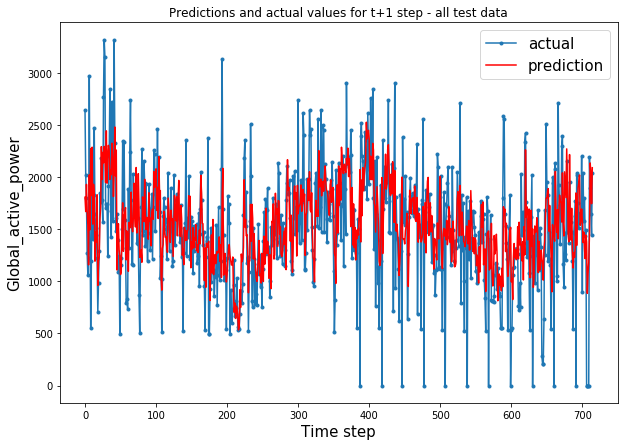

In [60]:
# RANDOM FORESTS MULTI-STEP 7 DAYS

from sklearn.ensemble import RandomForestRegressor

#classifiers = []
yhat = pd.DataFrame()
for k in range(7):
    model = RandomForestRegressor().fit(train_X, train_y.iloc[:,k])
    yhat['rf_'+str(k)] = model.predict(test_X)
    
inv_yhat = np.concatenate((test_X ,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = pd.DataFrame(inv_yhat).iloc[:,117:]

inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,117:]

temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
rmse = np.sum(temp)/7    
print('----------------------------')
print('Overall Test RMSE: %.3f' % rmse)

inter=[x for x in range(inv_y.shape[0])]
plt.figure(figsize = (10,7))
plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - all test data')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

RMSE t+1: 474.62690331670524
RMSE t+2: 461.33899621956004
RMSE t+3: 477.81362483871925
RMSE t+4: 497.2547100857522
RMSE t+5: 502.8862320093809
RMSE t+6: 605.3294793017212
RMSE t+7: 641.2525512612577
----------------------------
Overall Test RMSE: 522.929


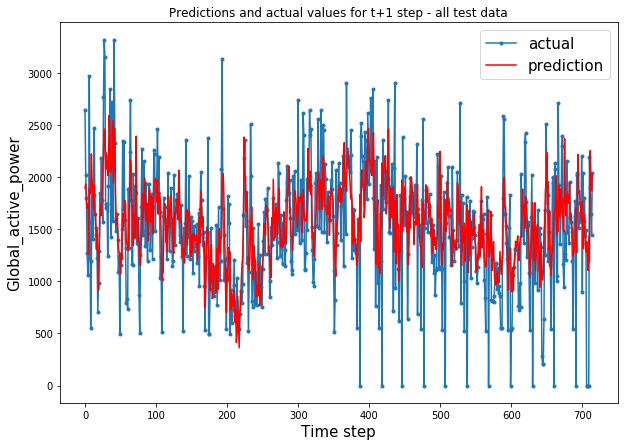

In [61]:
# GRADIENT BOOSTING

from sklearn.ensemble import GradientBoostingRegressor

yhat = pd.DataFrame()
for k in range(7):
    model = GradientBoostingRegressor().fit(train_X, train_y.iloc[:,k])
    yhat['rf_'+str(k)] = model.predict(test_X)
    
inv_yhat = np.concatenate((test_X ,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = pd.DataFrame(inv_yhat).iloc[:,117:]

inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,117:]

gbm_inv_y_save = inv_y.iloc[:,-1]
gbm_inv_yhat_save = inv_yhat.iloc[:,-1]

temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
rmse = np.sum(temp)/7    
print('----------------------------')
print('Overall Test RMSE: %.3f' % rmse)

inter=[x for x in range(inv_y.shape[0])]
plt.figure(figsize = (10,7))
plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - all test data')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

<br>
<div class="alert alert-warning">
<b>7. ASSESSMENT (~200 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
A bagging-based, random forest (RF), and boosting-based, gradient boosting (GBM) approach is chosen to deal with the instability of non-linear methods. Both perform much better than persistence model. GBM has highest performance (average RMSE of 522). It is still wrong by circa 1/3 of average daily energy consumption. Note that for both ensembles, RMSE increased from t+1 to t+7, which makes sense because it is further in the future. 

<br>
<br>
Word count: 69

</div>

## 7. Advanced Methods 

If you are confident, explore some of the more advanced methods that we covered in the course. 

For example, try and get a RNN working on the dataset you have chosen.

#### This section consists of serveral neural networks:<br>
- Model 1: Multivariate time series forecasting with NN
- Model 2: Multi-step forecasting of 7 days consumption ahead based on 1 time lag and all features available (see supervised framing section)
- Model 3: Multi-step forecasting of 7 days consumption ahead based on 7 time lag and all features available (see supervised framing section)

### Model 1:

In [62]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [63]:
# Working with data
values = d.values

# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
d1 = series_to_supervised(scaled, 1, 1)
d1 = d1[['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)','var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var8(t)', 'var9(t)', #use to predict
        'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', #need to predict
        'var9(t-1)']] #can be eliminated

# keep only the ones that need to be predicted
d1.drop(['var9(t-1)'], axis=1, inplace=True)


In [64]:
def network_model(data, split_ratio, parameter_to_estemate):
    dict1 = dict(zip([i for i in d.columns], range(-7, 0)))
    i = dict1[parameter_to_estemate]
    # Spliting and spaping the data
    split = int(split_ratio * len(d)) #Note: change the split for the faster model training
    train, test = data[:split], data[split:]
    train_X, train_y = train.values[:, :-7], train.values[:, -7]
    test_X, test_y = test.values[:, :-7], test.values[:, -7]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], 10)) #change to have same dimentions

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 2:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 2:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print(f'{parameter_to_estemate}, RMSE: {rmse}')
    
    plt.figure(figsize = (30,10))
    #train test loss
    plt.subplot(131)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    #Plot true labels
    plt.subplot(132)
    inter=[x for x in range(inv_y.shape[0])]
    plt.plot(inter, inv_y, marker='.', label="actual")
    plt.plot(inter, inv_yhat, 'r', label="prediction")
    plt.title('Predictions and actual values for t step')
    plt.ylabel('Global_active_power', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)

    #Plot predicted labels with the decision boundaries
    plt.subplot(133)
    inter=[x for x in range(30)]
    plt.plot(inter, inv_y[:30], marker='.', label="actual")
    plt.plot(inter, inv_yhat[:30], 'r', label="prediction")
    plt.title('Predictions and actual values for t+1 step - 1 month')
    plt.ylabel('Global_active_power', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.3020 - val_loss: 0.1663
Epoch 2/50
 - 0s - loss: 0.1330 - val_loss: 0.0983
Epoch 3/50
 - 0s - loss: 0.1081 - val_loss: 0.1044
Epoch 4/50
 - 0s - loss: 0.1034 - val_loss: 0.0920
Epoch 5/50
 - 0s - loss: 0.1003 - val_loss: 0.0901
Epoch 6/50
 - 0s - loss: 0.0978 - val_loss: 0.0892
Epoch 7/50
 - 0s - loss: 0.0965 - val_loss: 0.0878
Epoch 8/50
 - 0s - loss: 0.0951 - val_loss: 0.0868
Epoch 9/50
 - 0s - loss: 0.0939 - val_loss: 0.0859
Epoch 10/50
 - 0s - loss: 0.0929 - val_loss: 0.0852
Epoch 11/50
 - 0s - loss: 0.0919 - val_loss: 0.0847
Epoch 12/50
 - 0s - loss: 0.0912 - val_loss: 0.0843
Epoch 13/50
 - 0s - loss: 0.0906 - val_loss: 0.0841
Epoch 14/50
 - 0s - loss: 0.0903 - val_loss: 0.0840
Epoch 15/50
 - 0s - loss: 0.0898 - val_loss: 0.0838
Epoch 16/50
 - 0s - loss: 0.0895 - val_loss: 0.0837
Epoch 17/50

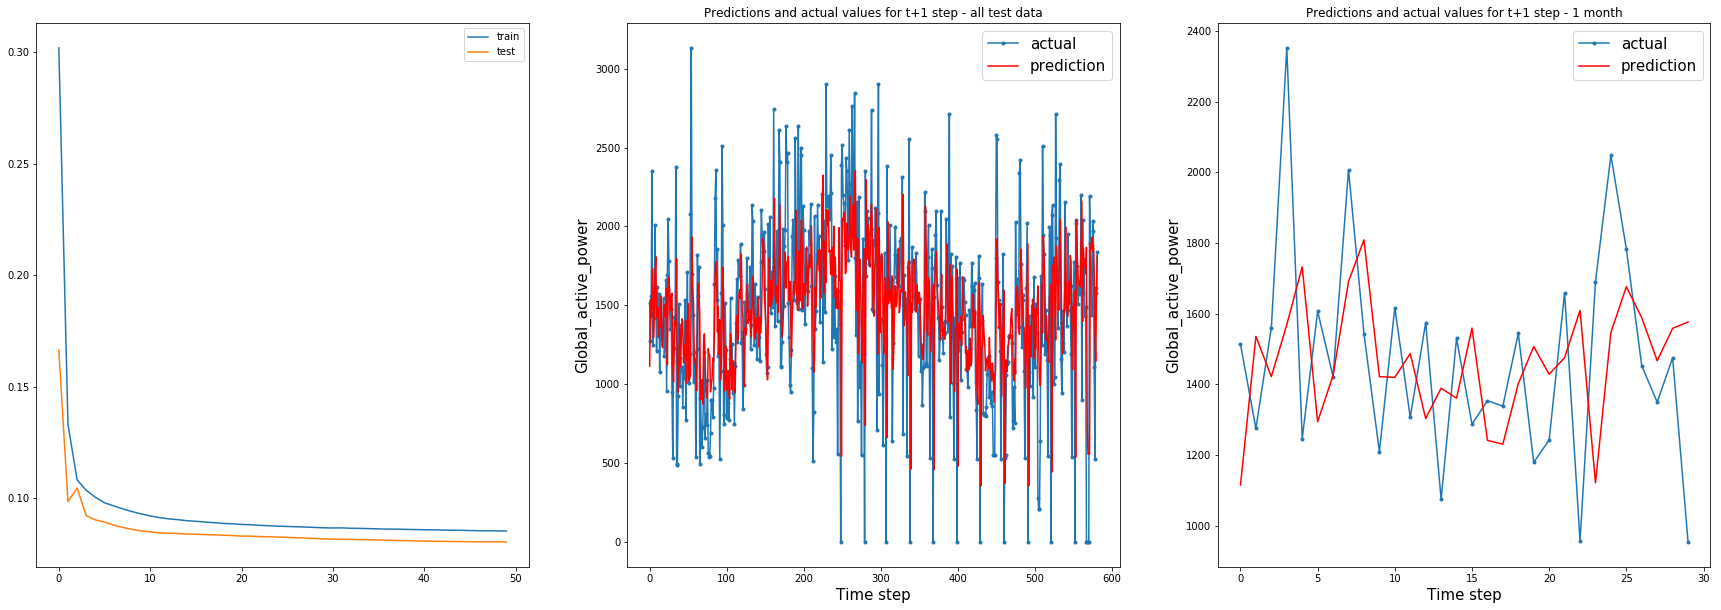

Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.3075 - val_loss: 0.1721
Epoch 2/50
 - 0s - loss: 0.1259 - val_loss: 0.1000
Epoch 3/50
 - 0s - loss: 0.1092 - val_loss: 0.1035
Epoch 4/50
 - 0s - loss: 0.1049 - val_loss: 0.0950
Epoch 5/50
 - 0s - loss: 0.1014 - val_loss: 0.0935
Epoch 6/50
 - 0s - loss: 0.0989 - val_loss: 0.0920
Epoch 7/50
 - 0s - loss: 0.0979 - val_loss: 0.0907
Epoch 8/50
 - 0s - loss: 0.0967 - val_loss: 0.0897
Epoch 9/50
 - 0s - loss: 0.0954 - val_loss: 0.0888
Epoch 10/50
 - 0s - loss: 0.0943 - val_loss: 0.0880
Epoch 11/50
 - 0s - loss: 0.0934 - val_loss: 0.0875
Epoch 12/50
 - 0s - loss: 0.0925 - val_loss: 0.0869
Epoch 13/50
 - 0s - loss: 0.0920 - val_loss: 0.0865
Epoch 14/50
 - 0s - loss: 0.0914 - val_loss: 0.0860
Epoch 15/50
 - 0s - loss: 0.0909 - val_loss: 0.0857
Epoch 16/50
 - 0s - loss: 0.0905 - val_loss: 0.0855
Epoch 17/50
 - 0s - loss: 0.0900 - val_loss: 0.0850
Epoch 18/50
 - 0s - loss: 0.0897 - val_loss: 0.0848
Epoch 19/50
 - 0s - loss: 0

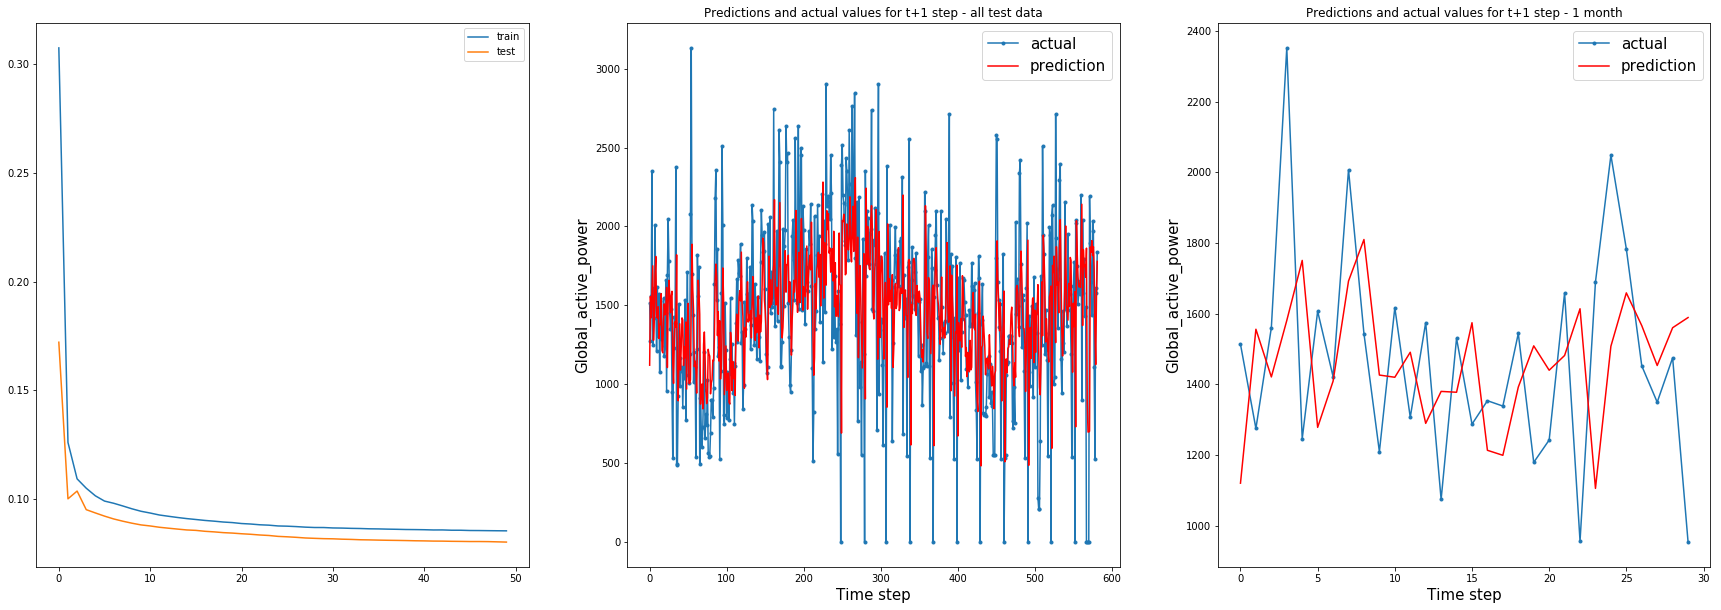

Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.2575 - val_loss: 0.1459
Epoch 2/50
 - 0s - loss: 0.1244 - val_loss: 0.1031
Epoch 3/50
 - 0s - loss: 0.1122 - val_loss: 0.1074
Epoch 4/50
 - 0s - loss: 0.1079 - val_loss: 0.0967
Epoch 5/50
 - 0s - loss: 0.1044 - val_loss: 0.0948
Epoch 6/50
 - 0s - loss: 0.1020 - val_loss: 0.0934
Epoch 7/50
 - 0s - loss: 0.1007 - val_loss: 0.0916
Epoch 8/50
 - 0s - loss: 0.0990 - val_loss: 0.0903
Epoch 9/50
 - 0s - loss: 0.0977 - val_loss: 0.0891
Epoch 10/50
 - 0s - loss: 0.0965 - val_loss: 0.0880
Epoch 11/50
 - 0s - loss: 0.0953 - val_loss: 0.0871
Epoch 12/50
 - 0s - loss: 0.0942 - val_loss: 0.0862
Epoch 13/50
 - 0s - loss: 0.0931 - val_loss: 0.0855
Epoch 14/50
 - 0s - loss: 0.0921 - val_loss: 0.0848
Epoch 15/50
 - 0s - loss: 0.0913 - val_loss: 0.0844
Epoch 16/50
 - 0s - loss: 0.0906 - val_loss: 0.0840
Epoch 17/50
 - 0s - loss: 0.0900 - val_loss: 0.0837
Epoch 18/50
 - 0s - loss: 0.0896 - val_loss: 0.0834
Epoch 19/50
 - 0s - loss: 0

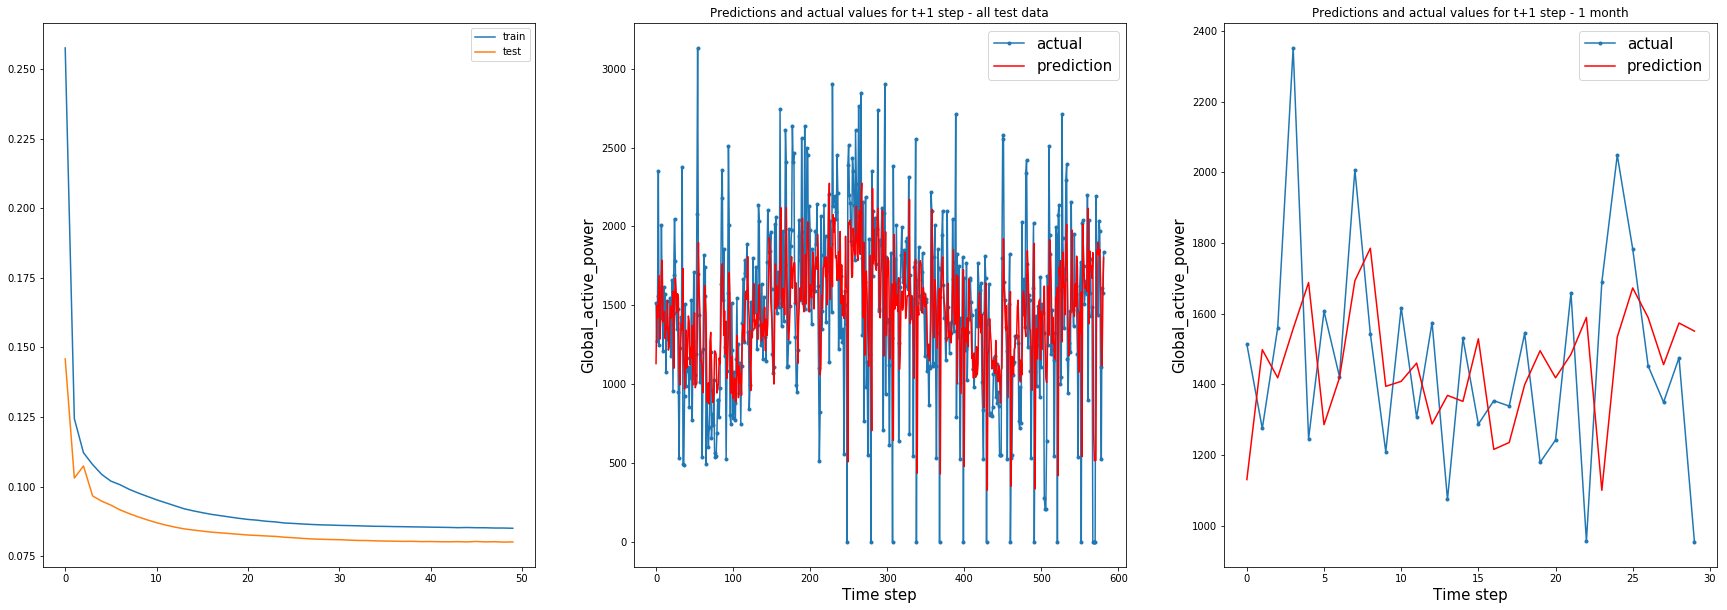

Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.3555 - val_loss: 0.2106
Epoch 2/50
 - 0s - loss: 0.1729 - val_loss: 0.1005
Epoch 3/50
 - 0s - loss: 0.1054 - val_loss: 0.1119
Epoch 4/50
 - 0s - loss: 0.1077 - val_loss: 0.0995
Epoch 5/50
 - 0s - loss: 0.1018 - val_loss: 0.0943
Epoch 6/50
 - 0s - loss: 0.0998 - val_loss: 0.0927
Epoch 7/50
 - 0s - loss: 0.0977 - val_loss: 0.0915
Epoch 8/50
 - 0s - loss: 0.0964 - val_loss: 0.0898
Epoch 9/50
 - 0s - loss: 0.0950 - val_loss: 0.0885
Epoch 10/50
 - 0s - loss: 0.0937 - val_loss: 0.0873
Epoch 11/50
 - 0s - loss: 0.0926 - val_loss: 0.0862
Epoch 12/50
 - 0s - loss: 0.0916 - val_loss: 0.0853
Epoch 13/50
 - 0s - loss: 0.0907 - val_loss: 0.0846
Epoch 14/50
 - 0s - loss: 0.0900 - val_loss: 0.0841
Epoch 15/50
 - 0s - loss: 0.0894 - val_loss: 0.0837
Epoch 16/50
 - 0s - loss: 0.0888 - val_loss: 0.0835
Epoch 17/50
 - 0s - loss: 0.0883 - val_loss: 0.0833
Epoch 18/50
 - 0s - loss: 0.0880 - val_loss: 0.0832
Epoch 19/50
 - 0s - loss: 0

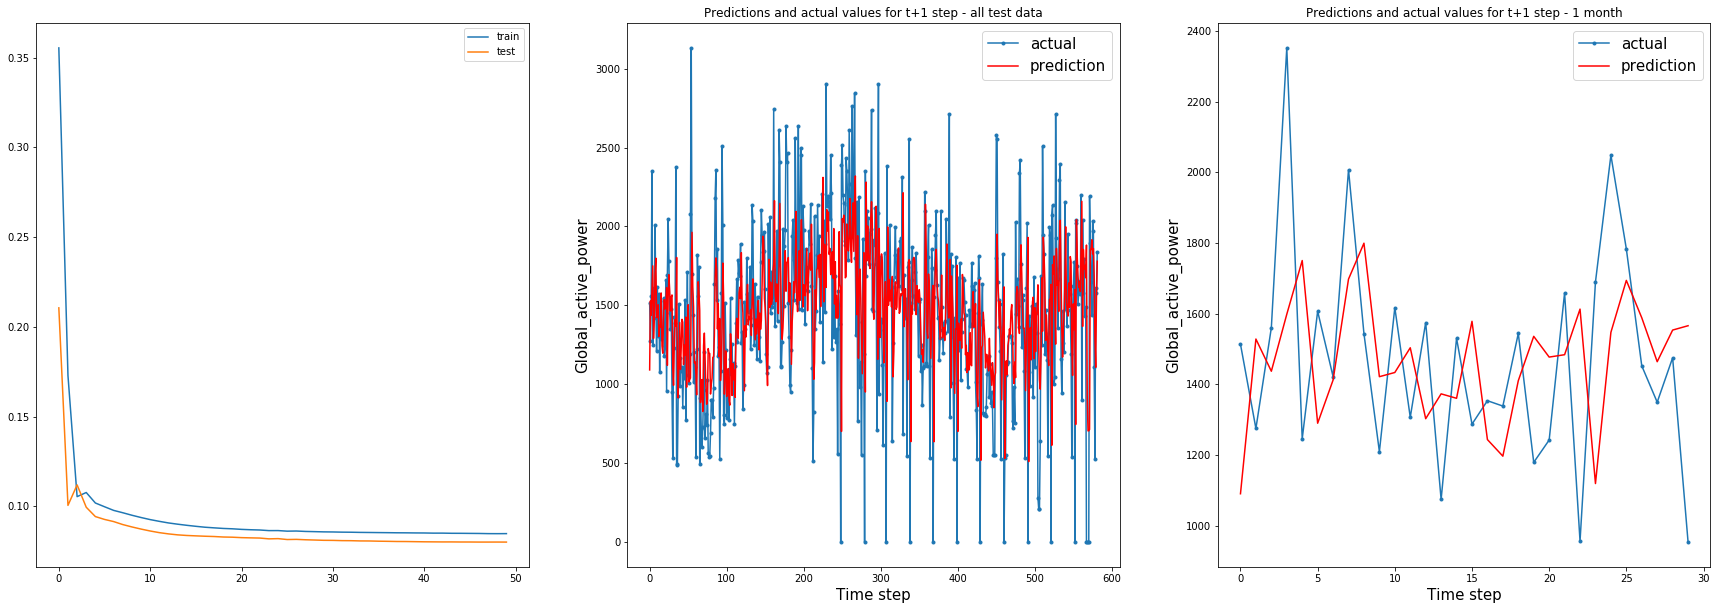

Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.2254 - val_loss: 0.1213
Epoch 2/50
 - 0s - loss: 0.1076 - val_loss: 0.1018
Epoch 3/50
 - 0s - loss: 0.1100 - val_loss: 0.0974
Epoch 4/50
 - 0s - loss: 0.1052 - val_loss: 0.0933
Epoch 5/50
 - 0s - loss: 0.1024 - val_loss: 0.0915
Epoch 6/50
 - 0s - loss: 0.1000 - val_loss: 0.0898
Epoch 7/50
 - 0s - loss: 0.0987 - val_loss: 0.0884
Epoch 8/50
 - 0s - loss: 0.0972 - val_loss: 0.0872
Epoch 9/50
 - 0s - loss: 0.0958 - val_loss: 0.0861
Epoch 10/50
 - 0s - loss: 0.0946 - val_loss: 0.0852
Epoch 11/50
 - 0s - loss: 0.0935 - val_loss: 0.0847
Epoch 12/50
 - 0s - loss: 0.0923 - val_loss: 0.0841
Epoch 13/50
 - 0s - loss: 0.0913 - val_loss: 0.0836
Epoch 14/50
 - 0s - loss: 0.0905 - val_loss: 0.0832
Epoch 15/50
 - 0s - loss: 0.0899 - val_loss: 0.0830
Epoch 16/50
 - 0s - loss: 0.0893 - val_loss: 0.0829
Epoch 17/50
 - 0s - loss: 0.0887 - val_loss: 0.0826
Epoch 18/50
 - 0s - loss: 0.0883 - val_loss: 0.0825
Epoch 19/50
 - 0s - loss: 0

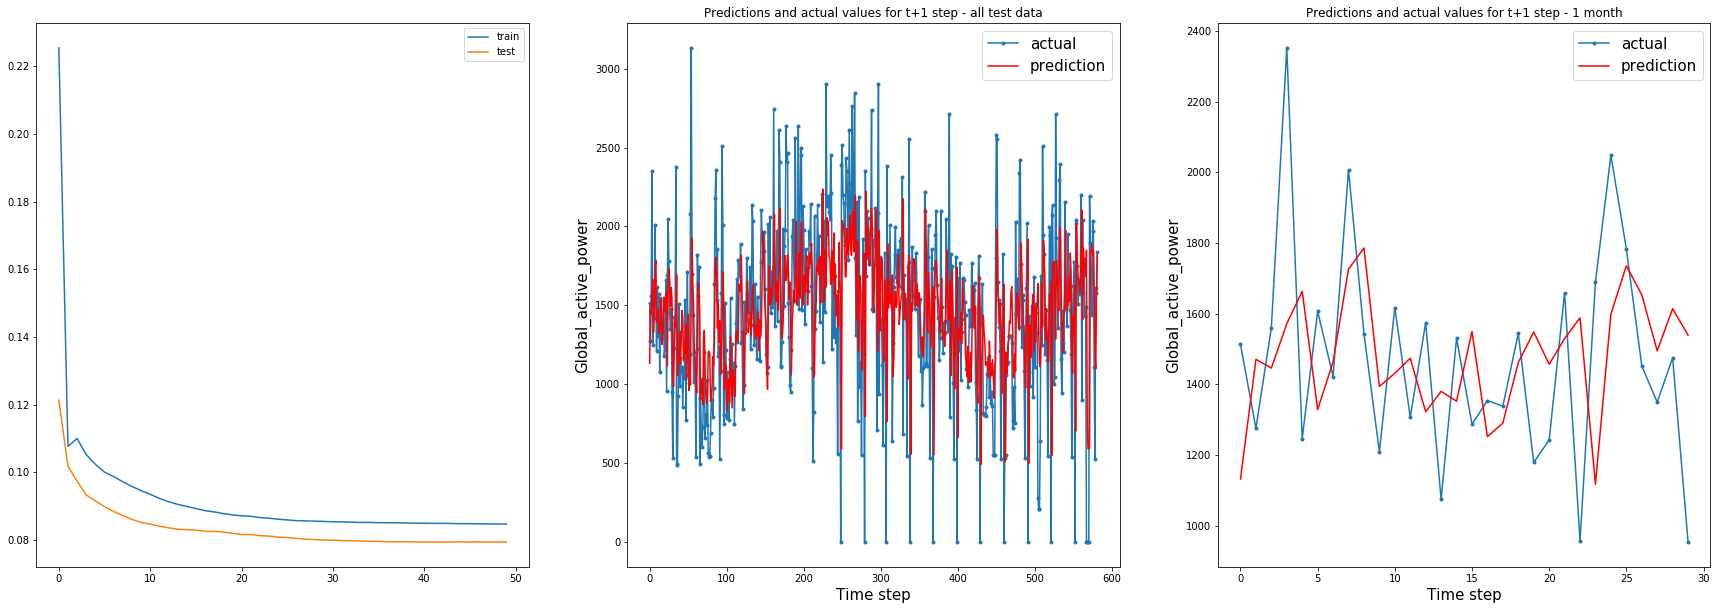

Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.2335 - val_loss: 0.1276
Epoch 2/50
 - 0s - loss: 0.1100 - val_loss: 0.1010
Epoch 3/50
 - 0s - loss: 0.1076 - val_loss: 0.0988
Epoch 4/50
 - 0s - loss: 0.1030 - val_loss: 0.0922
Epoch 5/50
 - 0s - loss: 0.1002 - val_loss: 0.0905
Epoch 6/50
 - 0s - loss: 0.0981 - val_loss: 0.0893
Epoch 7/50
 - 0s - loss: 0.0970 - val_loss: 0.0879
Epoch 8/50
 - 0s - loss: 0.0955 - val_loss: 0.0868
Epoch 9/50
 - 0s - loss: 0.0944 - val_loss: 0.0858
Epoch 10/50
 - 0s - loss: 0.0933 - val_loss: 0.0852
Epoch 11/50
 - 0s - loss: 0.0923 - val_loss: 0.0847
Epoch 12/50
 - 0s - loss: 0.0916 - val_loss: 0.0845
Epoch 13/50
 - 0s - loss: 0.0910 - val_loss: 0.0842
Epoch 14/50
 - 0s - loss: 0.0905 - val_loss: 0.0841
Epoch 15/50
 - 0s - loss: 0.0900 - val_loss: 0.0838
Epoch 16/50
 - 0s - loss: 0.0896 - val_loss: 0.0836
Epoch 17/50
 - 0s - loss: 0.0892 - val_loss: 0.0835
Epoch 18/50
 - 0s - loss: 0.0889 - val_loss: 0.0833
Epoch 19/50
 - 0s - loss: 0

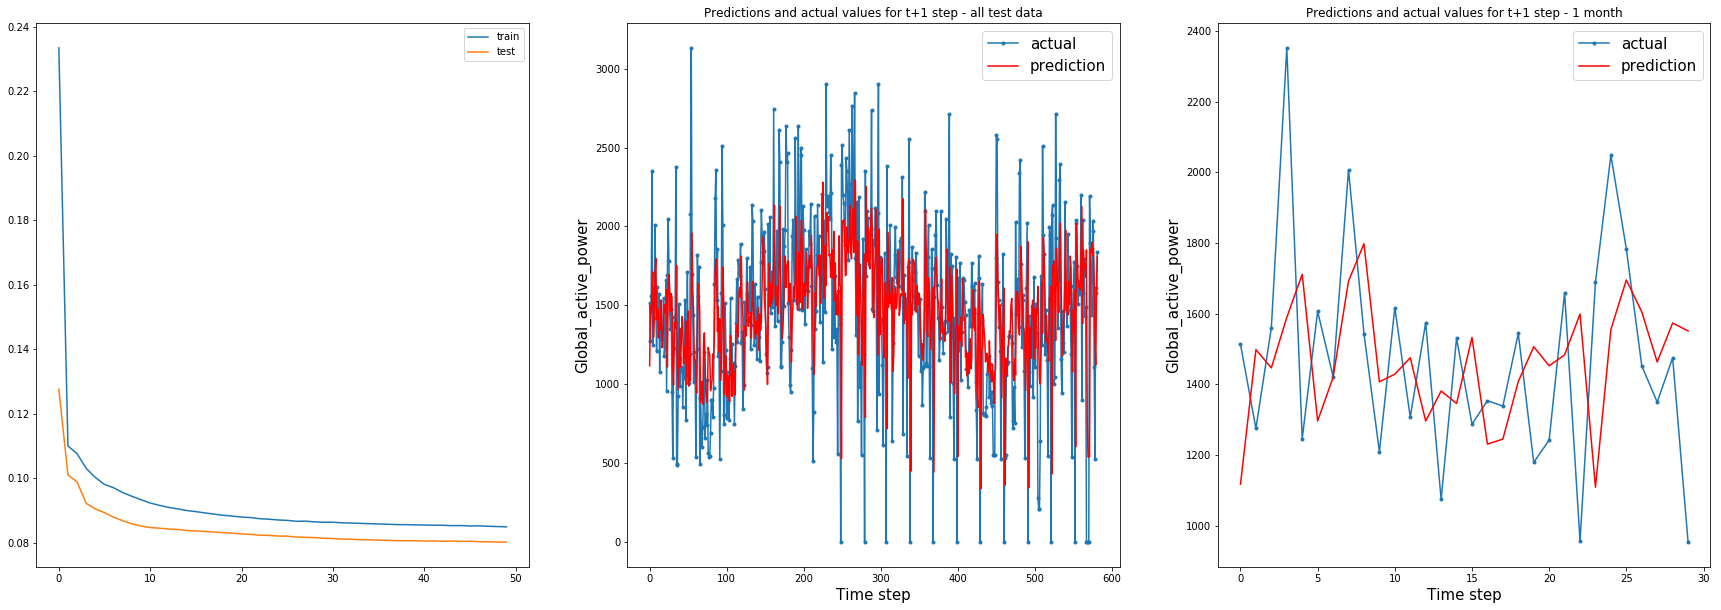

Train on 874 samples, validate on 582 samples
Epoch 1/50
 - 1s - loss: 0.1636 - val_loss: 0.0965
Epoch 2/50
 - 0s - loss: 0.1010 - val_loss: 0.1018
Epoch 3/50
 - 0s - loss: 0.1024 - val_loss: 0.0923
Epoch 4/50
 - 0s - loss: 0.0983 - val_loss: 0.0908
Epoch 5/50
 - 0s - loss: 0.0965 - val_loss: 0.0895
Epoch 6/50
 - 0s - loss: 0.0954 - val_loss: 0.0884
Epoch 7/50
 - 0s - loss: 0.0945 - val_loss: 0.0874
Epoch 8/50
 - 0s - loss: 0.0935 - val_loss: 0.0867
Epoch 9/50
 - 0s - loss: 0.0923 - val_loss: 0.0859
Epoch 10/50
 - 0s - loss: 0.0918 - val_loss: 0.0854
Epoch 11/50
 - 0s - loss: 0.0912 - val_loss: 0.0851
Epoch 12/50
 - 0s - loss: 0.0906 - val_loss: 0.0848
Epoch 13/50
 - 0s - loss: 0.0901 - val_loss: 0.0846
Epoch 14/50
 - 0s - loss: 0.0897 - val_loss: 0.0843
Epoch 15/50
 - 0s - loss: 0.0893 - val_loss: 0.0841
Epoch 16/50
 - 0s - loss: 0.0889 - val_loss: 0.0838
Epoch 17/50
 - 0s - loss: 0.0886 - val_loss: 0.0834
Epoch 18/50
 - 0s - loss: 0.0884 - val_loss: 0.0833
Epoch 19/50
 - 0s - loss: 0

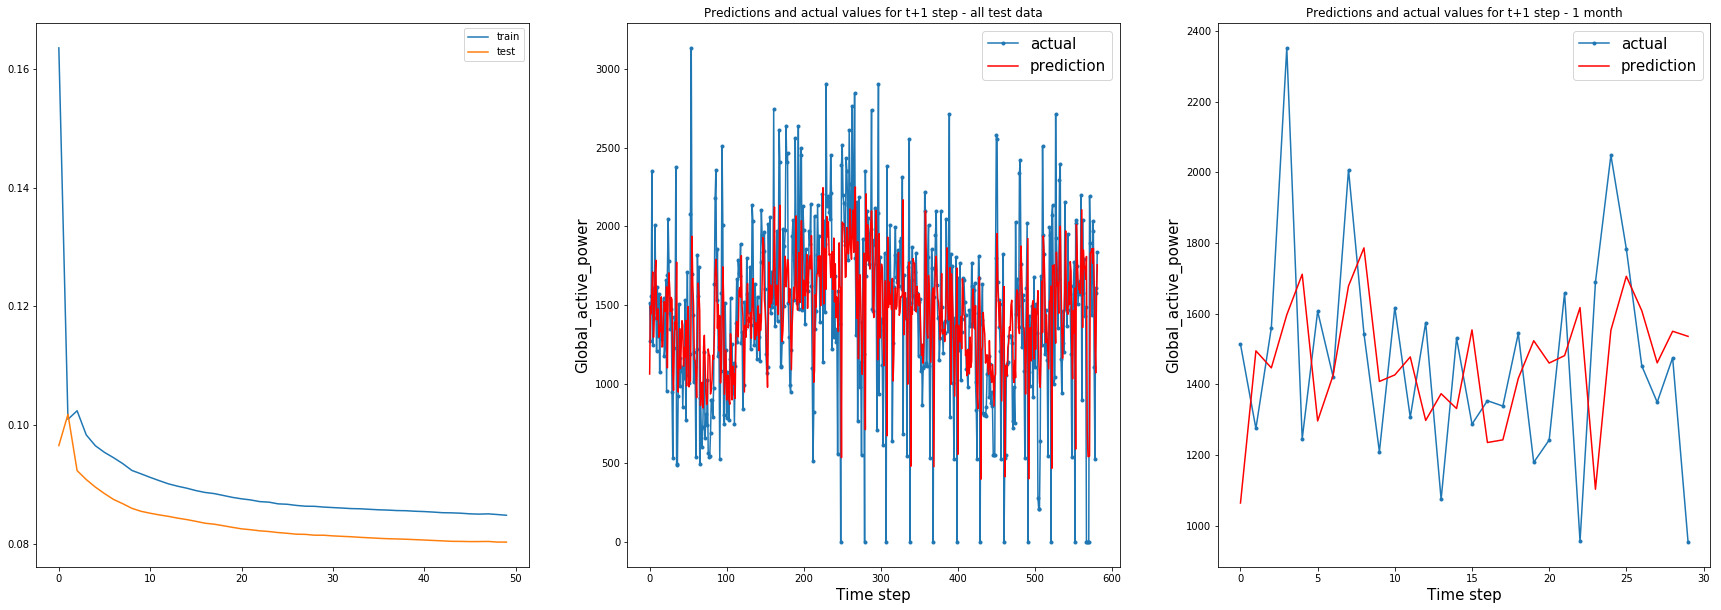

In [65]:
for i in d.columns[:7]:
    network_model(d1, 0.6, i )


<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>

This model looks at multivariate time series forcasting with the LSTM. For better forecast model considerate climate and weekend variables.
<br>
<br>
Word count: 19
</div>

### Keras: Multivariate time series forecasting with LSTMs
### Models 2 and 3:

In [66]:
# Two alternatives, model2 and model3
# Model 2 and 3 both predict multi-step although are based on different time lags

In [67]:
# Model 2 implementation: 1 time lag, all features plus weather and weekend features, 
# input format [samples, timesteps, features] = [samples, 1, 9]
from sklearn.preprocessing import MinMaxScaler
data = df_sup_all.iloc[:,12:20]
temp_df = pd.concat([df_sup_all.iloc[:,32:33],df_sup_all.iloc[:,52:53],df_sup_all.iloc[:,72:73],df_sup_all.iloc[:,92:93],df_sup_all.iloc[:,112:113],df_sup_all.iloc[:,132:133],df_sup_all.iloc[:,152:153],df_sup_all.iloc[:,172:173]],axis = 1)
data = pd.concat([temp_df,data],axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
n_train = int(0.5 * len(d))
train_X = data.iloc[:n_train,:9]
train_X = train_X.values.reshape(train_X.shape[0],1,train_X.shape[1])
train_y = data.iloc[:n_train,9:]
test_X = data.iloc[n_train:,:9]
test_X = test_X.values.reshape(test_X.shape[0],1,test_X.shape[1])
test_y = data.iloc[n_train:,9:]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((728, 1, 9), (728, 7), (715, 1, 9), (715, 7))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 728 samples, validate on 715 samples
Epoch 1/20
728/728 [==============================] - 2s 3ms/step - loss: 0.1142 - val_loss: 0.0245
Epoch 2/20
728/728 [==============================] - 0s 387us/step - loss: 0.0371 - val_loss: 0.0211
Epoch 3/20
728/728 [==============================] - 0s 418us/step - loss: 0.0303 - val_loss: 0.0205
Epoch 4/20
728/728 [==============================] - 0s 417us/step - loss: 0.0291 - val_loss: 0.0201
Epoch 5/20
728/728 [==============================] - 0s 425us/step - loss: 0.0289 - val_loss: 0.0198
Epoch 6/20
728/728 [==============================] - 0s 404us/step - loss: 0.0280 - val_loss: 0.0195
Epoch 7/20
728/728 [==============================] - 0s 404us/step - loss: 0.0275 - val_loss: 0.0193
Epoch 8/20
728/728 [==============================] - 0s 421us/step - loss: 0.0276 - val_loss: 0.0191
Epoch 9/20
728/728 [=====

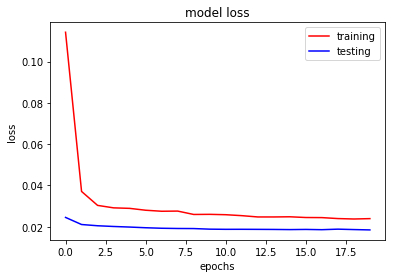

In [68]:
# lstm
# modelling choices

model = Sequential()
model.add(LSTM(200,activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(100,activation = 'relu',return_sequences=False))
model.add(Dense(7))
model.compile(loss='mse', optimizer='adam')

# fitting
history = model.fit(train_X, train_y, epochs=20, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# plot train and test performance/loss
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'testing'])
plt.show();

In [69]:
# prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 9))
# invert scaling for forecast
inv_yhat = np.concatenate((test_X ,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = pd.DataFrame(inv_yhat).iloc[:,9:]
# invert scaling for actual
###test_y = test_y.reshape((len(test_y), 7))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,9:]
# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

RMSE t+1: 527.2860719258958
RMSE t+2: 550.6433037445335
RMSE t+3: 556.7351567950427
RMSE t+4: 546.1067713432545
RMSE t+5: 549.6449245616575
RMSE t+6: 555.7242414512149
RMSE t+7: 544.7696398052311
Overall Test RMSE: 547.273


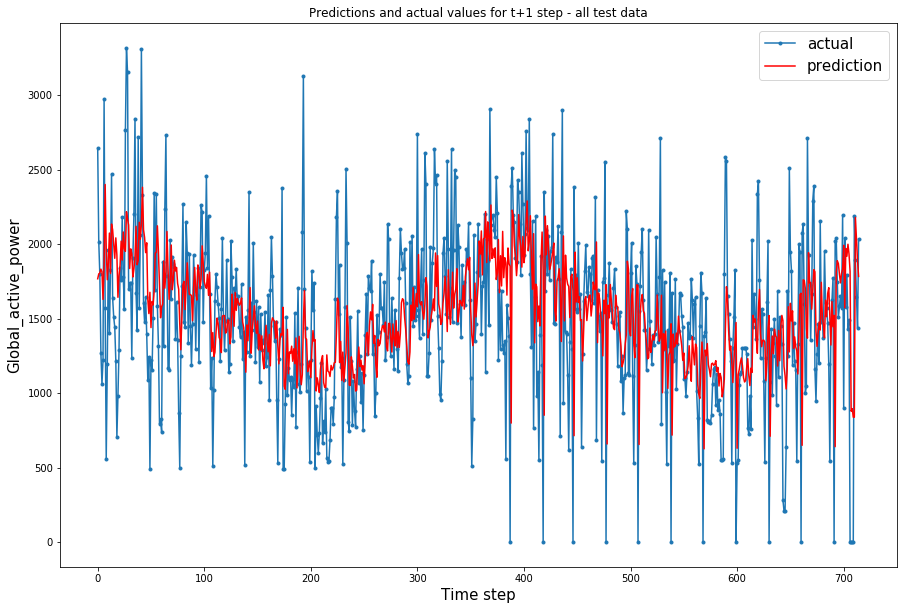

In [70]:
inter=[x for x in range(inv_y.shape[0])]
plt.figure(figsize = (15,10))
plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - all test data')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

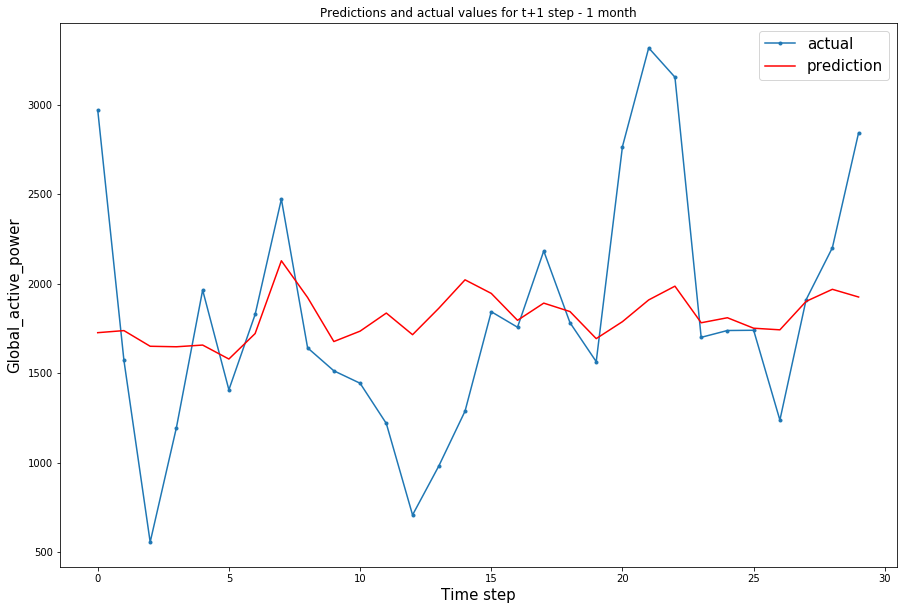

In [71]:
inter=[x for x in range(30)]
plt.figure(figsize = (15,10))
plt.plot(inter, inv_y.iloc[:30,-1], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:30,-1], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - 1 month')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [72]:
# Model 3: 7 lags, all features plus weather and weekend,
# input format [samples, timesteps, features] = [samples, 7, 9]
from sklearn.preprocessing import MinMaxScaler
data = df_sup_all.iloc[:,13:20]
temp_df_1 = pd.concat([df_sup_all.iloc[:,12:13],df_sup_all.iloc[:,32:33],df_sup_all.iloc[:,52:53],df_sup_all.iloc[:,72:73],df_sup_all.iloc[:,92:93],df_sup_all.iloc[:,112:113],df_sup_all.iloc[:,132:133],df_sup_all.iloc[:,152:153],df_sup_all.iloc[:,172:173]],axis = 1)
temp_df_2 = pd.concat([df_sup_all.iloc[:,11:12], df_sup_all.iloc[:,31:32],df_sup_all.iloc[:,51:52],df_sup_all.iloc[:,71:72],df_sup_all.iloc[:,91:92],df_sup_all.iloc[:,111:112],df_sup_all.iloc[:,131:132],df_sup_all.iloc[:,151:152],df_sup_all.iloc[:,171:172]],axis = 1)
temp_df_3 = pd.concat([df_sup_all.iloc[:,10:11], df_sup_all.iloc[:,30:31],df_sup_all.iloc[:,50:51],df_sup_all.iloc[:,70:71],df_sup_all.iloc[:,90:91],df_sup_all.iloc[:,110:111],df_sup_all.iloc[:,130:131],df_sup_all.iloc[:,150:151],df_sup_all.iloc[:,170:171]],axis = 1)
temp_df_4 = pd.concat([df_sup_all.iloc[:,9:10], df_sup_all.iloc[:,29:30],df_sup_all.iloc[:,49:50],df_sup_all.iloc[:,69:70],df_sup_all.iloc[:,89:90],df_sup_all.iloc[:,109:110],df_sup_all.iloc[:,129:130],df_sup_all.iloc[:,149:150],df_sup_all.iloc[:,169:170]],axis = 1)
temp_df_5 = pd.concat([df_sup_all.iloc[:,8:9], df_sup_all.iloc[:,28:29],df_sup_all.iloc[:,48:49],df_sup_all.iloc[:,68:69],df_sup_all.iloc[:,88:89],df_sup_all.iloc[:,108:109],df_sup_all.iloc[:,128:129],df_sup_all.iloc[:,148:149],df_sup_all.iloc[:,168:169]],axis = 1)
temp_df_6 = pd.concat([df_sup_all.iloc[:,7:8], df_sup_all.iloc[:,27:28],df_sup_all.iloc[:,47:48],df_sup_all.iloc[:,67:68],df_sup_all.iloc[:,87:88],df_sup_all.iloc[:,107:108],df_sup_all.iloc[:,127:128],df_sup_all.iloc[:,147:148],df_sup_all.iloc[:,167:168]],axis = 1)
temp_df_7 = pd.concat([df_sup_all.iloc[:,6:7], df_sup_all.iloc[:,26:27],df_sup_all.iloc[:,46:47],df_sup_all.iloc[:,66:67],df_sup_all.iloc[:,86:87],df_sup_all.iloc[:,106:107],df_sup_all.iloc[:,126:127],df_sup_all.iloc[:,146:147],df_sup_all.iloc[:,166:167]],axis = 1)
data = pd.concat([temp_df_7,temp_df_6,temp_df_5,temp_df_4,temp_df_3,temp_df_2,temp_df_1,data],axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
n_train = int(0.5 * len(d))
train_X = data.iloc[:n_train,:63]
train_X = train_X.values.reshape(train_X.shape[0],7,9)
train_y = data.iloc[:n_train,63:]
test_X = data.iloc[n_train:,:63]
test_X = test_X.values.reshape(test_X.shape[0],7,9)
test_y = data.iloc[n_train:,63:]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((728, 7, 9), (728, 7), (715, 7, 9), (715, 7))

Train on 728 samples, validate on 715 samples
Epoch 1/15
728/728 [==============================] - 3s 4ms/step - loss: 0.1032 - val_loss: 0.0342
Epoch 2/15
728/728 [==============================] - 0s 662us/step - loss: 0.0408 - val_loss: 0.0257
Epoch 3/15
728/728 [==============================] - 0s 657us/step - loss: 0.0306 - val_loss: 0.0202
Epoch 4/15
728/728 [==============================] - 0s 654us/step - loss: 0.0278 - val_loss: 0.0194
Epoch 5/15
728/728 [==============================] - 0s 643us/step - loss: 0.0280 - val_loss: 0.0189
Epoch 6/15
728/728 [==============================] - 0s 662us/step - loss: 0.0270 - val_loss: 0.0185
Epoch 7/15
728/728 [==============================] - 0s 657us/step - loss: 0.0263 - val_loss: 0.0183
Epoch 8/15
728/728 [==============================] - 0s 666us/step - loss: 0.0258 - val_loss: 0.0181
Epoch 9/15
728/728 [==============================] - 0s 658us/step - loss: 0.0253 - val_loss: 0.0180
Epoch 10/15
728/728 [=================

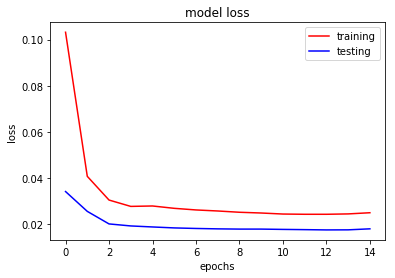

In [73]:
# modelling choices

model = Sequential()
model.add(LSTM(200,activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100,activation = 'relu',return_sequences=False))
model.add(Dense(7))
model.compile(loss='mse', optimizer='adam')

# fitting
history = model.fit(train_X, train_y, epochs=15, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# plot train and test performance/loss
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'testing'])
plt.show();

In [74]:
# prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 63))
# invert scaling for forecast
inv_yhat = np.concatenate((test_X ,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = pd.DataFrame(inv_yhat).iloc[:,63:]
# invert scaling for actual
###test_y = test_y.reshape((len(test_y), 7))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,63:]
# calculate RMSE, combine
temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
rmse = np.sum(temp)/7    
print('Overall Test RMSE: %.3f' % rmse)

RMSE t+1: 546.8194506718961
RMSE t+2: 545.2043566119096
RMSE t+3: 541.9051715572791
RMSE t+4: 542.5966352036232
RMSE t+5: 541.6541858985922
RMSE t+6: 540.968064864412
RMSE t+7: 537.9681635135206
Overall Test RMSE: 542.445


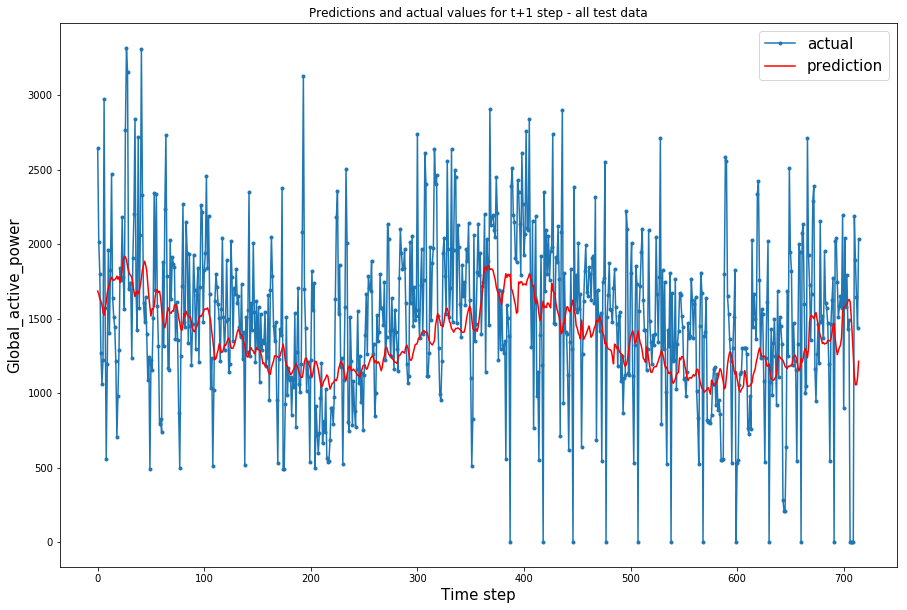

In [75]:
inter=[x for x in range(inv_y.shape[0])]
plt.figure(figsize = (15,10))
plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:inv_y.shape[0],0], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - all test data')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

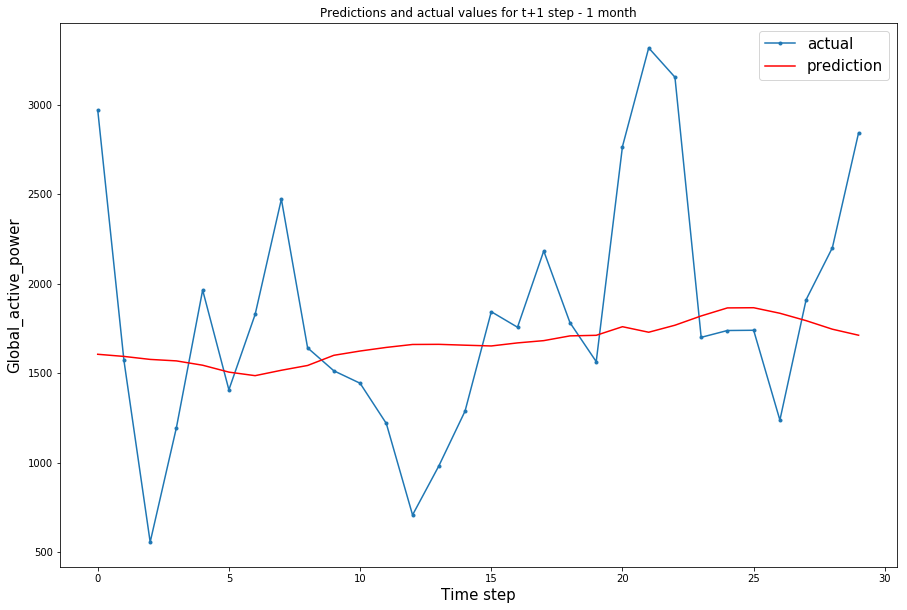

In [76]:
inter=[x for x in range(30)]
plt.figure(figsize = (15,10))
plt.plot(inter, inv_y.iloc[:30,-1], marker='.', label="actual")
plt.plot(inter, inv_yhat.iloc[:30,-1], 'r', label="prediction")
plt.title('Predictions and actual values for t+1 step - 1 month')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

<br>
<div class="alert alert-success">
<b>8. OPTIONAL ASSESSMENT (~200 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
Models 2 and 3: based on the data engineering in the supervised framing section. Model 2 is an LSTM that feeds in only 1 time lag but all available 9 features. The input structure is [#samples, timesteps, features] = [#samples, 1, 9]. It uses two LSTM layers and a 0.5 dropout to predict 7 outcomes (t+1…t+7). 

Model 3: LSTM that feeds in 7 time lag but all available variables. The input structure is [#samples, 7, 9]. The architecture is similar. Model 2 reaches an average RMSE of 553 which increases fast in predicted time steps. Model 3, although build on more lags, performs similar but the RMSE does not increase (from t+1 to t+7), therefore it is a more stable model.

All models show a higher training loss compared to the testing loss (see graphs above) which logically does not make sense to us although it might have to do with the drop-outs or how Keras handles training and testing differently. Also, we are convinced that the neural nets would perform better if they would have been trained on an appropriate amount of data (we only have 728 training samples available in this case study). 

<br>
<br>
Word count: 195

</div>

<br>
<div class="alert alert-success">
<h1 align="center"> 5. Algorithm further assesment </h1> <br>
<a id="assesment"></a>

## Evaluation

You have trained more that two different regressors using different methods and tested it on different dataset. 

Comment on the comparative performance of the methods your have investigated. 

In [77]:
# This section contains:
# 1) GBM - Experiment: Change the train test-test split from 50/50 to 60/40 and show that lack of data might be an issue
# 2) GBM - Plot true vs. predicted values and visualise the performance of the best multi-step model
# 3) Take the difference between the predictions and the true values of the t+1 step of the 7 day multi-step GBM system
# 4) The mark up cell gives an overview about comparability of results

In [78]:
# 1) GBM - Experiment: Change the train test-test split from 0.5/0.5 to 0.6/0.4 and show that lack of data is an issue
# Create a direct modelling approach

data = df_sup_all.iloc[:,13:20]
temp_df = pd.concat([df_sup_all.iloc[:,0:13], df_sup_all.iloc[:,20:33],df_sup_all.iloc[:,40:53],df_sup_all.iloc[:,60:73],df_sup_all.iloc[:,80:93],df_sup_all.iloc[:,100:113],df_sup_all.iloc[:,120:133],df_sup_all.iloc[:,140:153],df_sup_all.iloc[:,160:173]],axis = 1)
df_direct = pd.concat([temp_df,data],axis = 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_direct = scaler.fit_transform(df_direct)
df_direct = pd.DataFrame(df_direct)
n_train = int(0.6 * len(d))
train_X = df_direct.iloc[:n_train,:117]
train_y = df_direct.iloc[:n_train,117:]
test_X = df_direct.iloc[n_train:,:117]
test_y = df_direct.iloc[n_train:,117:]
#train_X.shape, train_y.shape, test_X.shape, test_y.shape

# GRADIENT BOOSTING - MULTI-STEP 7 DAYS

from sklearn.ensemble import GradientBoostingRegressor

yhat = pd.DataFrame()
for k in range(7):
    model = GradientBoostingRegressor().fit(train_X, train_y.iloc[:,k])
    yhat['rf_'+str(k)] = model.predict(test_X)
    
inv_yhat = np.concatenate((test_X ,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = pd.DataFrame(inv_yhat).iloc[:,117:]

inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = pd.DataFrame(inv_y).iloc[:,117:]

gbm_inv_y_save = inv_y.iloc[:,-1]
gbm_inv_yhat_save = inv_yhat.iloc[:,-1]

temp = list()
for k in range(7):
    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
rmse = np.sum(temp)/7    
print('----------------------------')
print('Overall Test RMSE with the 60/40 split: %.3f' % rmse)
print('Compare: Overall Test RMSE with the 50/50 split: 523ish')

RMSE t+1: 481.64416745246007
RMSE t+2: 480.88253590373375
RMSE t+3: 486.34288104114245
RMSE t+4: 490.3136625807303
RMSE t+5: 491.1814237942388
RMSE t+6: 513.1442612933137
RMSE t+7: 591.4945050993113
----------------------------
Overall Test RMSE with the 60/40 split: 505.000
Compare: Overall Test RMSE with the 50/50 split: 523ish


In [79]:
#----------------------------
#Overall Test RMSE with the 60/40 split: 506.052
#Compare: Overall Test RMSE with the 50/50 split: 523ish

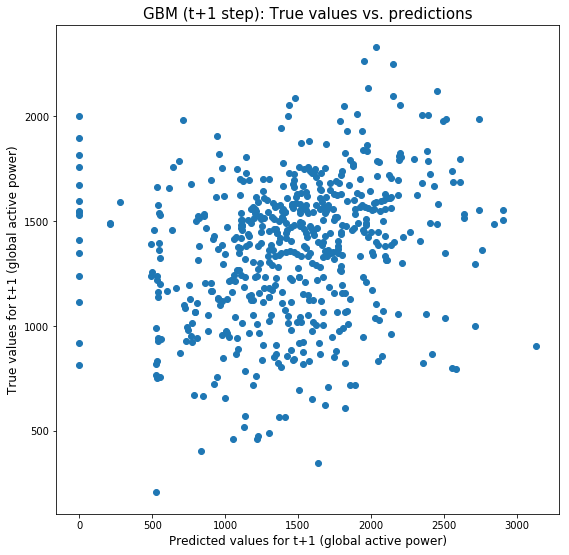

In [80]:
# 2) True values vs. predictions - still far from a 45 degree line
plt.figure(figsize = (9,9))
plt.scatter(gbm_inv_y_save,gbm_inv_yhat_save)
plt.title('GBM (t+1 step): True values vs. predictions', fontsize = 15)
plt.ylabel('True values for t+1 (global active power)', size=12)
plt.xlabel('Predicted values for t+1 (global active power)', size=12)
plt.show();

In [81]:
# 3) Take the difference between the predictions and the true values of the t+1 step of the 7 day multi-step GBM system
# Note: The following statistics are based on the model above (60/40 split).

In [82]:
diff_gbm = gbm_inv_yhat_save-gbm_inv_y_save

In [83]:
# mean != median -> slightly right-skewed distribution of residuals
diff_gbm.mean(), diff_gbm.median()
# For comparision:
# The experiment in this section (60/40 split) results in: (-84.15365986985809, -82.67020167824012)
# The regular model in the notebook (50/50 split) results in: (-151.80721716904435, -128.53251884434917)
# The mean residual is twice as high!!

(-97.34566834807268, -83.31591231734114)

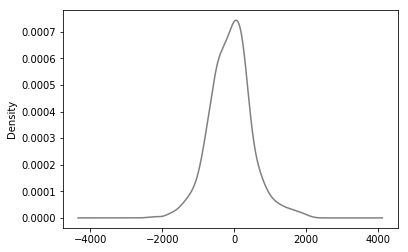

In [84]:
# Plot the residuals - the shape looks quite good although the upper tail is irregular 
# The residuals are distributed quite symmetric but the variance of the distribution is quite big, especially see the long tails!
# This makes the model costly for us.
diff_gbm.plot(kind='kde', color='grey');

In [85]:
# See the quantiles
diff_gbm.describe()

count     569.000000
mean      -97.345668
std       583.942504
min     -2227.514034
25%      -470.218146
50%       -83.315912
75%       227.401934
max      2001.470298
Name: 123, dtype: float64

<br>
<div class="alert alert-warning">
<b>9. ASSESSMENT (~200 words)</b> 

<p> Put your narrative or explanatory text in this cell (or additional cells as necessary) <p>

</div>

<div class="alert alert-block alert-info">
    
<b>SECTION COMPREHENSION</b>
<br>
<br>
All models are based on the same train-test split. Some models (ARIMA and one LSTM) are doing one-step forecasting, other models (supervised base nd ensembles, 2 LSTMs) are performing multi-step forecast. The choice of the persistence model could have been different as well (e.g. use t-1 instead of t-7 for prediciton of t). The most severe issue we see is the lack of data: We work on a 728 sample train set which is not much to train an algorithm, especially not the LSTMs. The experiment above shows that a 60/40 (instead of 50/50) split decreases RMSE for GMB by 20 already. Second, the data structure changes in the last year and models might be not able to generalise sufficiently. Third, some models are built on more lags and more features than others. Models after the supervised section are comparable. The plot above shows that the predictions vs. true values for GMB do not form a 45 degree line. The result shows that there is lots of potential to improve the predicitve ability of our system. 
<br>
<br>
Word count: 176

</div>

<br>
<div class="alert alert-success">
<h1 align="center"> 6. Finalize Model and Summary </h1> <br>
<a id="final"></a>

In [86]:
#neural network model:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# make a prediction
yhat = model.predict(test_X)
    
#it can be accest throught the function:
#network_model(data, train_test_split, column of the chose of estimation)
#it was run in the 7th section of thisnotbook, all results avaliable there
    
    

In [87]:
%%time
# GRID SEARCH VROSS VALIDATION OF GRADIENT BOOSTING

# !!!
# NOTE: DO NOT RUN. We used GridSreachCV to find optimal parameters. It runs for 30 min but the results are not better than the default settings.
# So for a final model, see the GBM model in the ensemble section of this notebook. RMSE: 522 (7 days multi-step, direct modeling approach)
# !!!

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# By using the supervised data frame, the time-variant/dependent information for each point in time is captured in each row, therefore the rows itself
# become time-independent. We can therefore use standard cross-validation with a grid search to find the optimal parameters for all 7 models.

#  set paramter ranges
parameters = {
    "loss":["ls"],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth":[2,3,5],
    "min_samples_split":[2,4,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.7, 0.85, 0.9],
    "n_estimators":[100, 200, 500]
    }

#note that the following code runs 
#optimised_models = list()
#yhat = pd.DataFrame()
#for k in range(7):
#    model = GridSearchCV(GradientBoostingRegressor(), parameters,scoring='neg_mean_squared_error',cv=5)
#    model.fit(train_X, train_y.iloc[:,k])
#    yhat['gb_'+str(k)] = model.predict(test_X)
#    print('gb_'+str(k)+' GridSearchCV successful')
#    optimised_models.append(model)
    
#print('----------------------------')
#inv_yhat = np.concatenate((test_X ,yhat), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = pd.DataFrame(inv_yhat).iloc[:,117:]

#inv_y = np.concatenate((test_X, test_y), axis=1#)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = pd.DataFrame(inv_y).iloc[:,117:]

#temp = list()
#for k in range(7):
#    print('RMSE t+'+str(k+1)+': '+str(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k]))))
#    temp.append(np.sqrt(mean_squared_error(inv_y.iloc[:,k], inv_yhat.iloc[:,k])))
#rmse = np.sum(temp)/7    
#print('----------------------------')
#print('Overall Test RMSE: %.3f' % rmse)

#inter=[x for x in range(inv_y.shape[0])]
#plt.figure(figsize = (10,7))
#plt.plot(inter, inv_y.iloc[:inv_y.shape[0],0], marker='.', label="actual")
#plt.plot(inter, inv_yhat.iloc[:inv_y.shape[0],0], 'r', label="prediction")
#plt.title('Predictions and actual values for t+1 step - all test data')
#plt.ylabel('Global_active_power', size=15)
#plt.xlabel('Time step', size=15)
#plt.legend(fontsize=15)
#plt.show();

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 28.6 µs


In [ ]:
# all seven models available here, just print the first
#optimised_models[0]

<div class="alert alert-warning">
<b>Summary: </b> <br>
    
As our analysis showed following models were most accurate in their classes:<br>
- The ARIMA yields an RMSE of <b>671</b>.<br>
- The best model overall: ensamble gradient boosted with RMSE of <b>525</b>.<br>
- The best supervised model: polynomial Ridge regression wiht RMSE of <b>899</b>.<br>
- The best NN model: Model 3 with 7 lags, all features plus weather and weekend with RMSE of <b>538</b>.<br>
- ARIMA performance with RMSE of <b>696</b>.<br>
- The evualuation shows that more data would have been needed for training of the models
- Using more than 7 days as time lags might increase the predictive ability of the system
<br>
<br>
Word count: 90

</div>

<div class="alert alert-warning">
<b>Sources: </b> <br>
Code for Neural Networks:  <br>
https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial <br>
https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/<br>

</div>

<div class="alert alert-block alert-info">
    
<b>WORD COUNT</b>
<br>
<br>
Notebook 1: 634 <br>
Notebook 2: 1200<br>
<br>
Total word count: < 2000 

</div>